In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import scipy
import scipy.stats as sps
import math

import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import (
    cross_val_score,
    KFold,
    cross_validate,
    cross_val_predict,
)
from sklearn.preprocessing import LabelEncoder, RobustScaler
from sklearn.metrics import mean_squared_error

import catboost
import lightgbm as lgb

import shap
import random

# Тщательный анализ данных

In [2]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
sample_submission = pd.read_csv("submission.csv")

target_name = "SalePrice"
target = train_df[target_name]

In [3]:
train_df.shape, test_df.shape

((1460, 81), (1459, 80))

In [4]:
df = pd.concat((train_df, test_df), axis = 0)

## Наличие пропусков

In [5]:
train_df.describe()

Id   MSSubClass  LotFrontage        LotArea  OverallQual  \
count  1460.000000  1460.000000  1201.000000    1460.000000  1460.000000   
mean    730.500000    56.897260    70.049958   10516.828082     6.099315   
std     421.610009    42.300571    24.284752    9981.264932     1.382997   
min       1.000000    20.000000    21.000000    1300.000000     1.000000   
25%     365.750000    20.000000    59.000000    7553.500000     5.000000   
50%     730.500000    50.000000    69.000000    9478.500000     6.000000   
75%    1095.250000    70.000000    80.000000   11601.500000     7.000000   
max    1460.000000   190.000000   313.000000  215245.000000    10.000000   

       OverallCond    YearBuilt  YearRemodAdd   MasVnrArea   BsmtFinSF1  ...  \
count  1460.000000  1460.000000   1460.000000  1452.000000  1460.000000  ...   
mean      5.575342  1971.267808   1984.865753   103.685262   443.639726  ...   
std       1.112799    30.202904     20.645407   181.066207   456.098091  ...   
min       1.000000  1872.000000   1950.000000     0.000000     0.000000  ...   
25%       5.000000  1954.000000   1967.000000     0.000000     0.000000  ...   
50%       5.000000  1973.000000   1994.000000     0.000000   383.500000  ...   
75%       6.000000  2000.000000   2004.000000   166.000000   712.250000  ...   
max       9.000000  2010.000000   2010.000000  1600.000000  5644.000000  ...   

        WoodDeckSF  OpenPorchSF  EnclosedPorch    3SsnPorch  ScreenPorch  \
count  1460.000000  1460.000000    1460.000000  1460.000000  1460.000000   
mean     94.244521    46.660274      21.954110     3.409589    15.060959   
std     125.338794    66.256028      61.119149    29.317331    55.757415   
min       0.000000     0.000000       0.000000     0.000000     0.000000   
25%       0.000000     0.000000       0.000000     0.000000     0.000000   
50%       0.000000    25.000000       0.000000     0.000000     0.000000   
75%     168.000000    68.000000       0.000000     0.000000     0.000000   
max     857.000000   547.000000     552.000000   508.000000   480.000000   

          PoolArea       MiscVal       MoSold       YrSold      SalePrice  
count  1460.000000   1460.000000  1460.000000  1460.000000    1460.000000  
mean      2.758904     43.489041     6.321918  2007.815753  180921.195890  
std      40.177307    496.123024     2.703626     1.328095   79442.502883  
min       0.000000      0.000000     1.000000  2006.000000   34900.000000  
25%       0.000000      0.000000     5.000000  2007.000000  129975.000000  
50%       0.000000      0.000000     6.000000  2008.000000  163000.000000  
75%       0.000000      0.000000     8.000000  2009.000000  214000.000000  
max     738.000000  15500.000000    12.000000  2010.000000  755000.000000  

[8 rows x 38 columns]

In [6]:
s = train_df.isna().mean()
s[s > 0]

LotFrontage     0.177397
Alley           0.937671
MasVnrType      0.005479
MasVnrArea      0.005479
BsmtQual        0.025342
BsmtCond        0.025342
BsmtExposure    0.026027
BsmtFinType1    0.025342
BsmtFinType2    0.026027
Electrical      0.000685
FireplaceQu     0.472603
GarageType      0.055479
GarageYrBlt     0.055479
GarageFinish    0.055479
GarageQual      0.055479
GarageCond      0.055479
PoolQC          0.995205
Fence           0.807534
MiscFeature     0.963014
dtype: float64

In [7]:
columns_with_miss = train_df.columns[train_df.isna().any(axis=0)]
train_df[columns_with_miss].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 19 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   LotFrontage   1201 non-null   float64
 1   Alley         91 non-null     object 
 2   MasVnrType    1452 non-null   object 
 3   MasVnrArea    1452 non-null   float64
 4   BsmtQual      1423 non-null   object 
 5   BsmtCond      1423 non-null   object 
 6   BsmtExposure  1422 non-null   object 
 7   BsmtFinType1  1423 non-null   object 
 8   BsmtFinType2  1422 non-null   object 
 9   Electrical    1459 non-null   object 
 10  FireplaceQu   770 non-null    object 
 11  GarageType    1379 non-null   object 
 12  GarageYrBlt   1379 non-null   float64
 13  GarageFinish  1379 non-null   object 
 14  GarageQual    1379 non-null   object 
 15  GarageCond    1379 non-null   object 
 16  PoolQC        7 non-null      object 
 17  Fence         281 non-null    object 
 18  MiscFeature   54 non-null   

### Предпринято
В работе были использованы различные подходы работы с пустыми значениями - некоторые модели использовали удаление признаков с пустыми значениями, некоторые заполняли средними значениями, некоторые использовали интерполяцию (Iterative imputing)

In [8]:
float_columns = [
    "LotFrontage",
    "LotArea",
    "MasVnrArea",
    "BsmtFinSF1",
    "BsmtFinSF2",
    "BsmtUnfSF",
    "1stFlrSF",
    "2ndFlrSF",
    "LowQualFinSF",
    "GrLivArea",
    "TotRmsAbvGrd",
    "GarageArea",
    "TotalBsmtSF",
    "WoodDeckSF",
    "OpenPorchSF",
    "EnclosedPorch",
    "3SsnPorch",
    "ScreenPorch",
    "PoolArea",
    "OverallQual",
    "GarageYrBlt",
    "YearBuilt",
    "YearRemodAdd",
]

categorical_columns = [
    "MSSubClass",
    "MSZoning",
    "Alley",
    "LotShape",
    "LandContour",
    "Utilities",
    "LotConfig",
    "LandSlope",
    "Neighborhood",
    "Condition1",
    "Condition2",
    "BldgType",
    "HouseStyle",
    "OverallCond",
    "RoofStyle",
    "RoofMatl",
    "Exterior1st",
    "Exterior2nd",
    "MasVnrType",
    "ExterQual",
    "ExterCond",
    "Foundation",
    "BsmtQual",
    "BsmtCond",
    "BsmtExposure",
    "BsmtFullBath",
    "BsmtFinType1",
    "BsmtFinType2",
    "Heating",
    "HeatingQC",
    "Electrical",
    "KitchenQual",
    "Functional",
    "FireplaceQu",
    "GarageFinish",
    "GarageQual",
    "GarageCond",
    "PavedDrive",
    "PoolQC",
    "Fence",
    "MiscFeature",
    "SaleType",
    "SaleCondition",
    "BsmtFullBath",
    "BsmtHalfBath",
    "FullBath",
    "HalfBath",
    "BedroomAbvGr",
    "KitchenAbvGr",
    "Fireplaces",
    "GarageType",
    "GarageCars",
    "YrSold",
    "MoSold",
    "Street", 
    "CentralAir"]


## Проверка наличия категорий в тестовой выборке, которых не было в обучающей
Проверяется наличие всех категорий используемых в тестовой выборке в обучающей.

In [9]:
for col in categorical_columns:
    diff = set(test_df[col].unique()).difference(set(train_df[col].unique()))
    if (len(diff) > 0) :
        print(col)
        print(set(test_df[col].unique()).difference(set(train_df[col].unique())))


MSSubClass
{150}
MSZoning
{nan}
Utilities
{nan}
Exterior1st
{nan}
Exterior2nd
{nan}
BsmtFullBath
{nan}
KitchenQual
{nan}
Functional
{nan}
SaleType
{nan}
BsmtFullBath
{nan}
BsmtHalfBath
{nan}
FullBath
{4}
Fireplaces
{4}
GarageCars
{nan, 5.0}


### Вывод
Только в одной переменной найдена такая ситуация - количество образцев с такой категорией мало, поэтому проблема не рассматривается отдельно

# Распределение целевой переменной

График распределения показывает явное смещение центра веса выборки влево. Преобразование Бокса-кокса помогает избавится от этой проблемы. В некоторых из моделей это преобразование было использовано в качестве препроцессинга в обучении.

<AxesSubplot:ylabel='Count'>

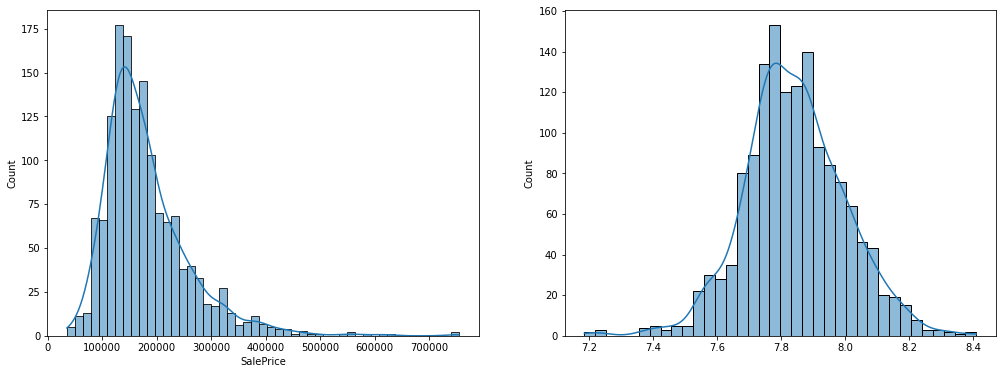

In [10]:
fig,(ax1,ax2) = plt.subplots(1,2, figsize = (17,6))
sns.histplot(train_df['SalePrice'], kde=True, ax=ax1)
target_normal, boxcox_lambda = scipy.stats.boxcox(target)
sns.histplot(target_normal, kde=True, ax=ax2)

<AxesSubplot:xlabel='SalePrice'>

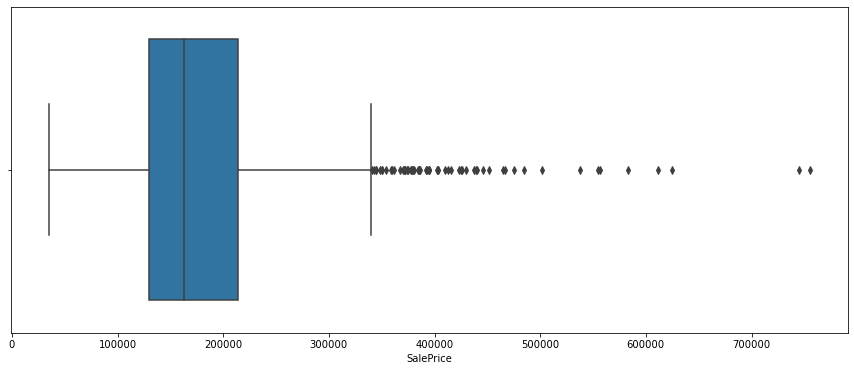

In [11]:
plt.figure(figsize=(15,6))
sns.boxplot(x = target_name, data = train_df)

In [12]:
def plot_box_hist(cat):
    f, (a0, a1) = plt.subplots(
        1, 2, gridspec_kw={"width_ratios": [2, 1]}, figsize=(19, 5)
    )
    sns.boxplot(x=cat, y=target_name, data=train_df.fillna("None"), ax=a0)
    plt.setp(a0.get_xticklabels(), rotation=45)
    sns.histplot(data=train_df[cat].fillna("None").astype(str), ax=a1)
    plt.setp(a1.get_xticklabels(), rotation=45)
    f.tight_layout()

    rects = a1.patches
    labels = [cat.get_text() for cat in a1.get_xticklabels()]
    labels = [
        "{}".format((train_df[cat].astype(str) == label).sum()) for label in labels
    ]
    for rect, label in zip(rects, labels):
        height = rect.get_height()
        a1.text(
            rect.get_x() + rect.get_width() / 2,
            height + 0.01,
            label,
            ha="center",
            va="bottom",
        )
    plt.show()


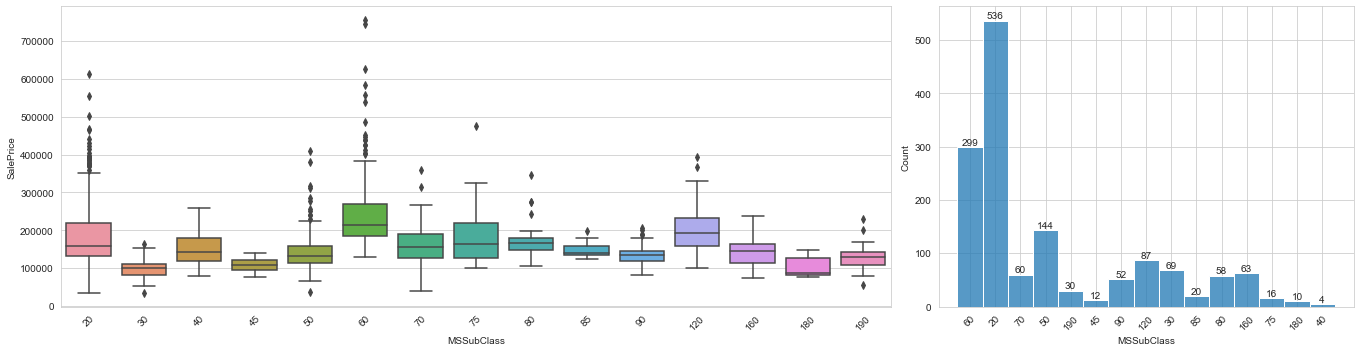

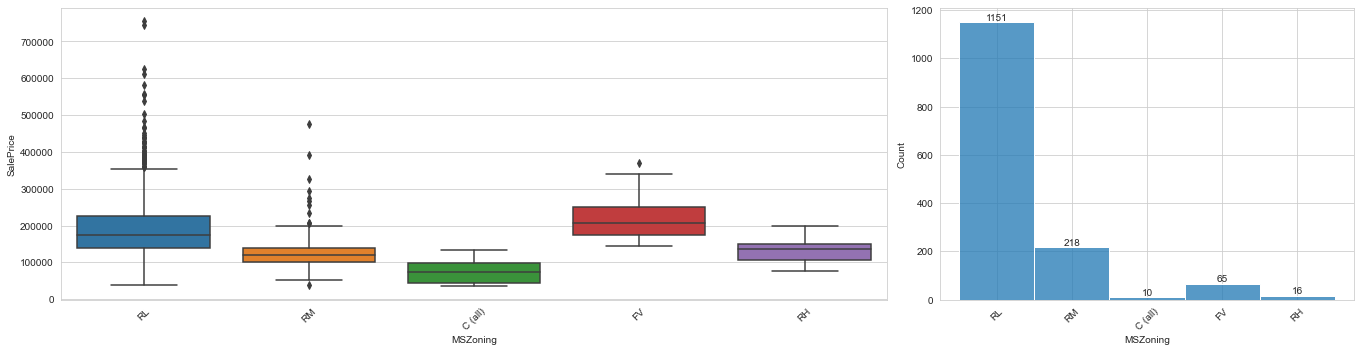

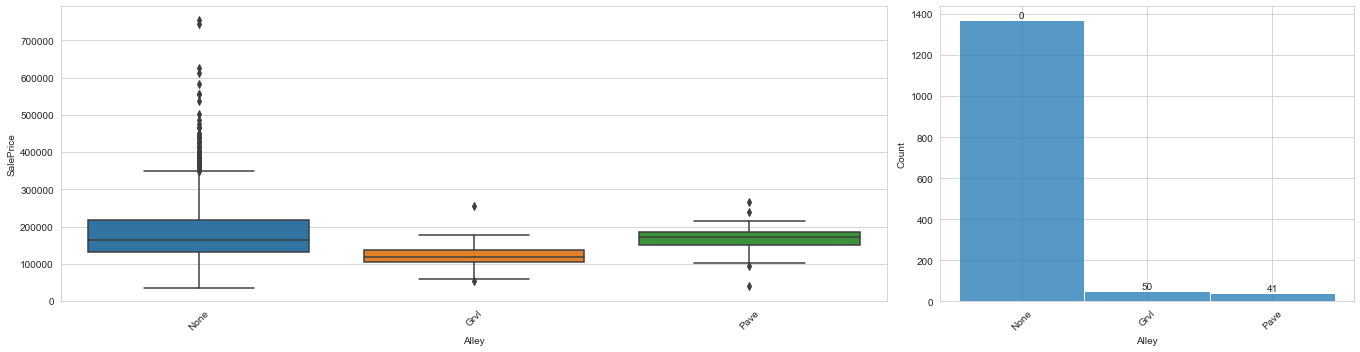

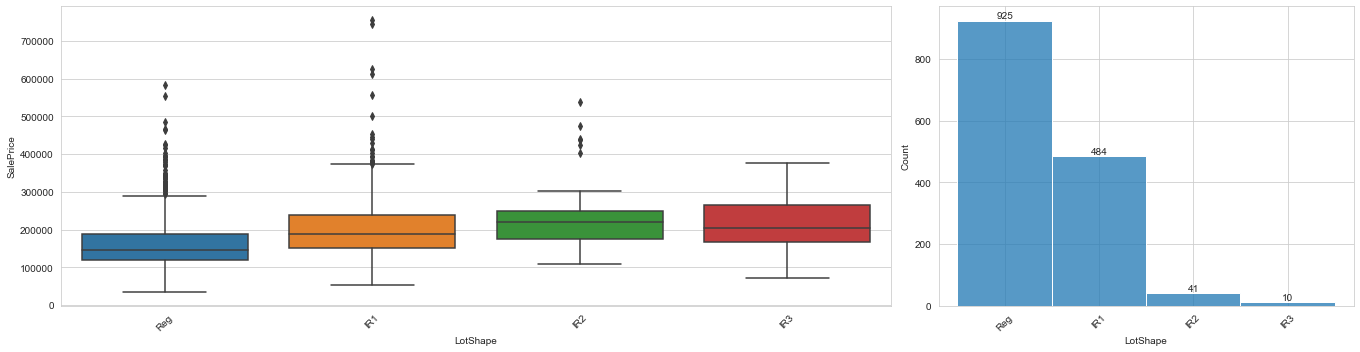

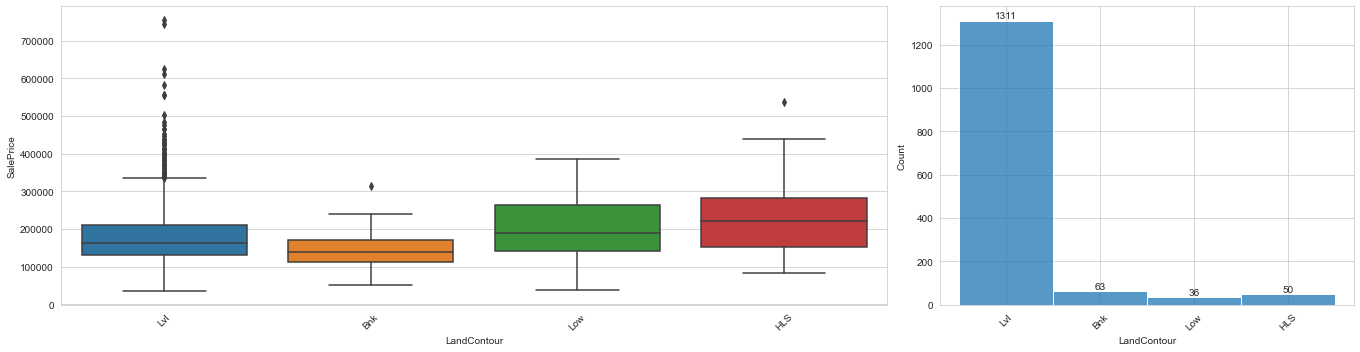

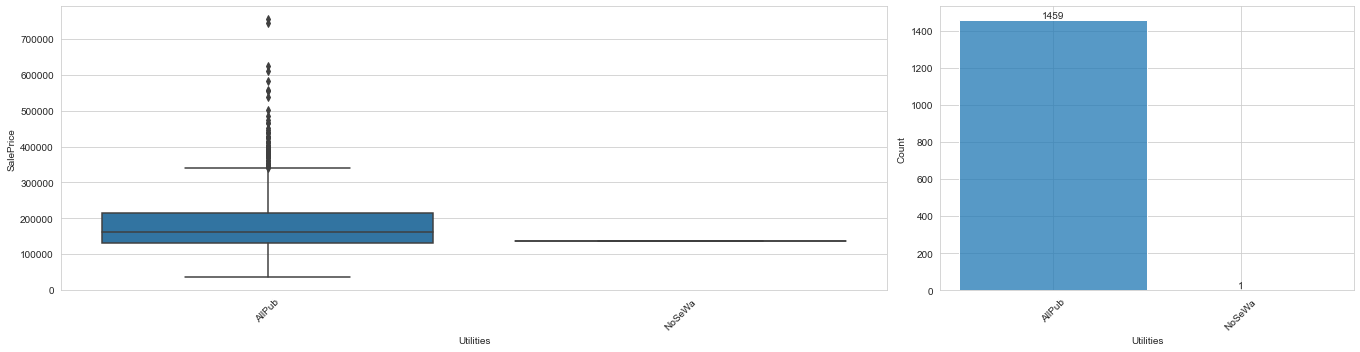

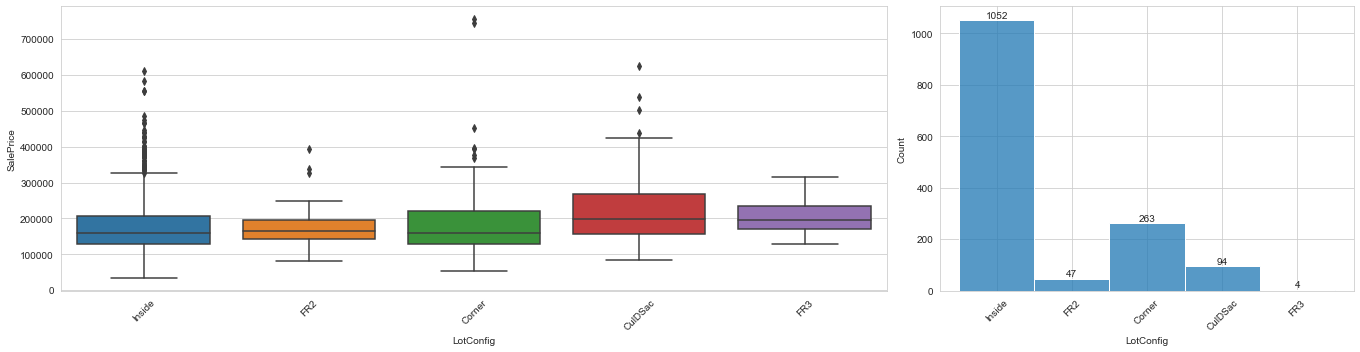

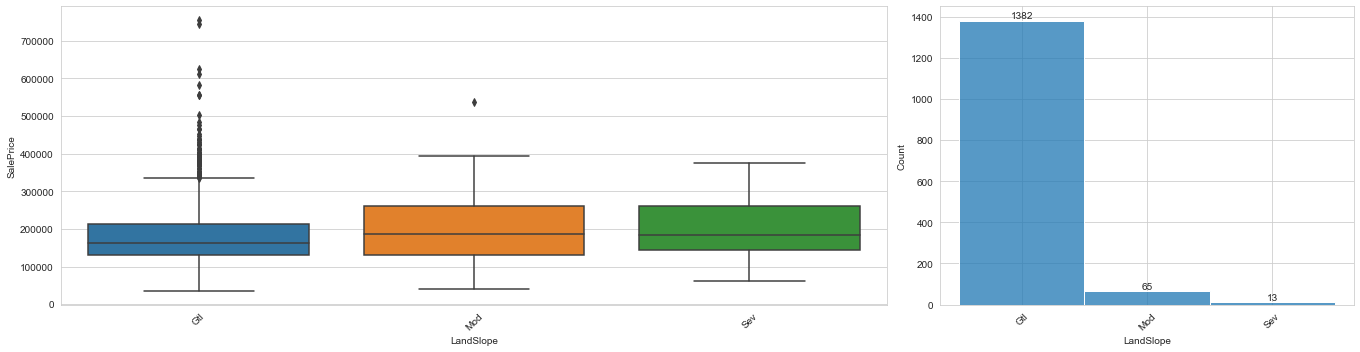

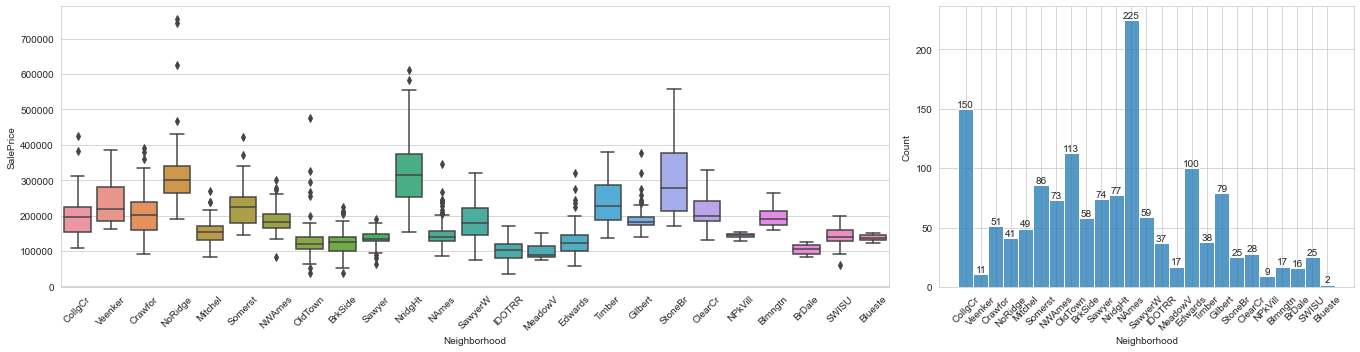

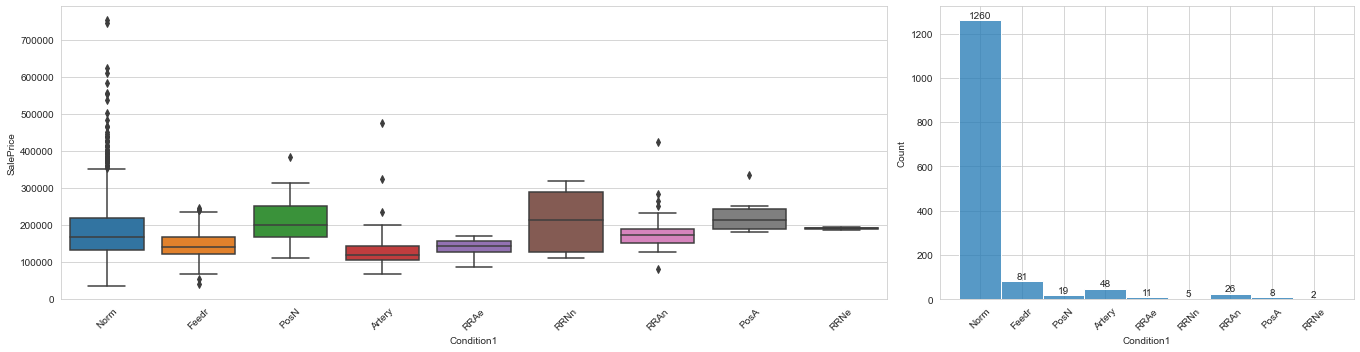

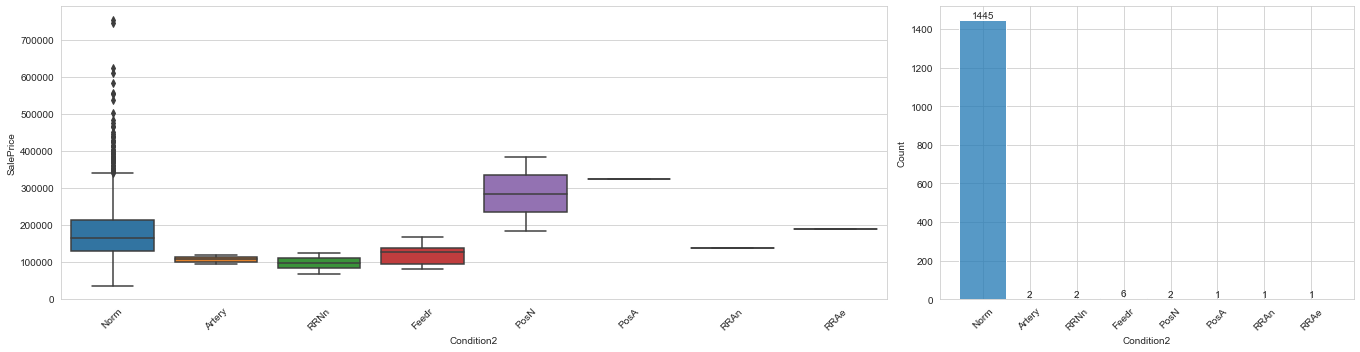

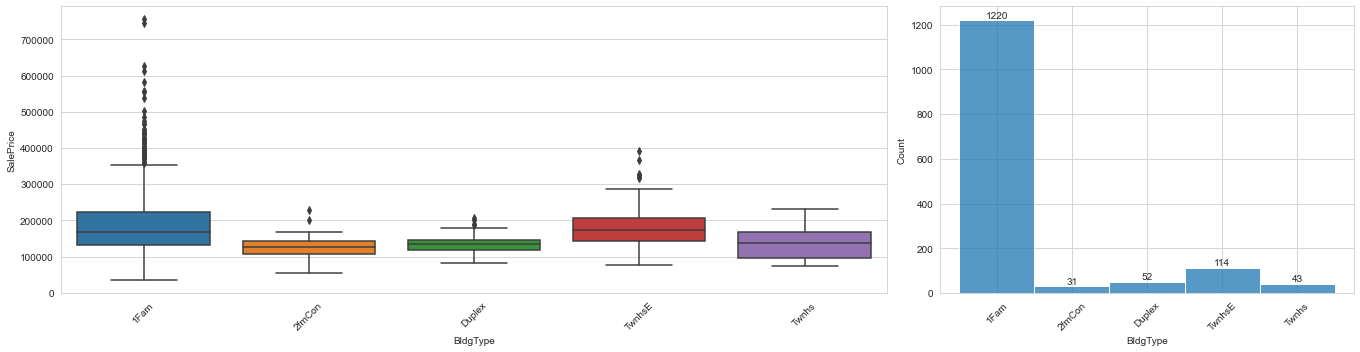

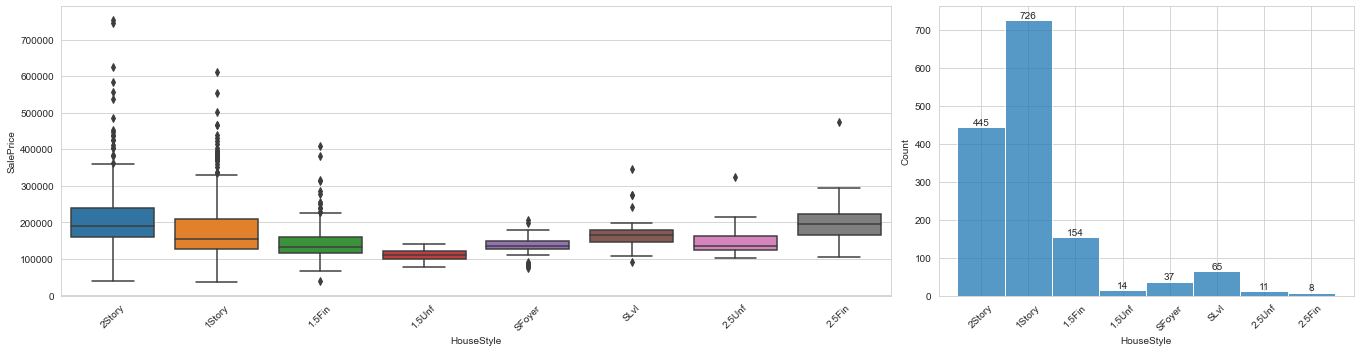

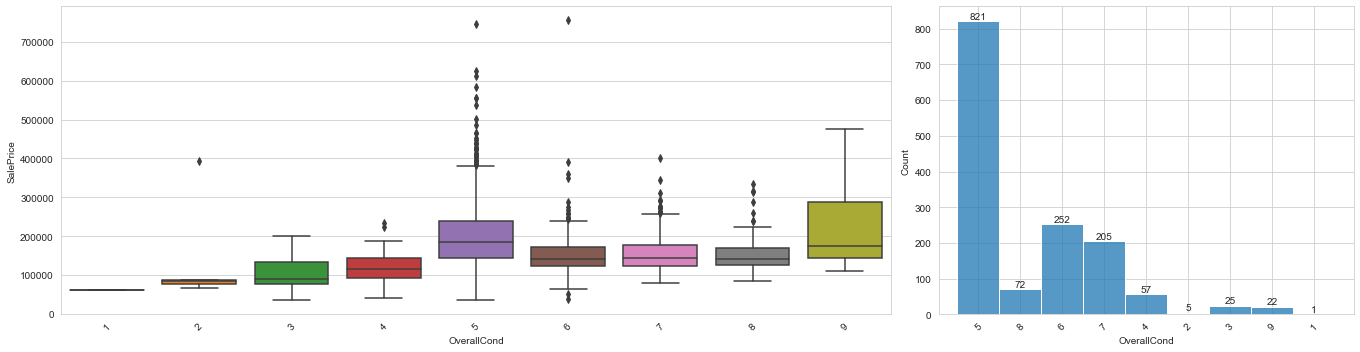

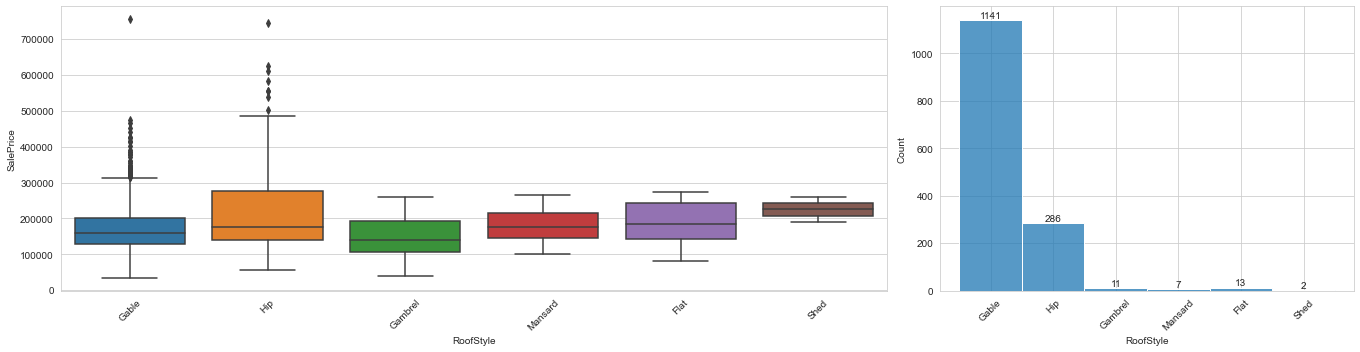

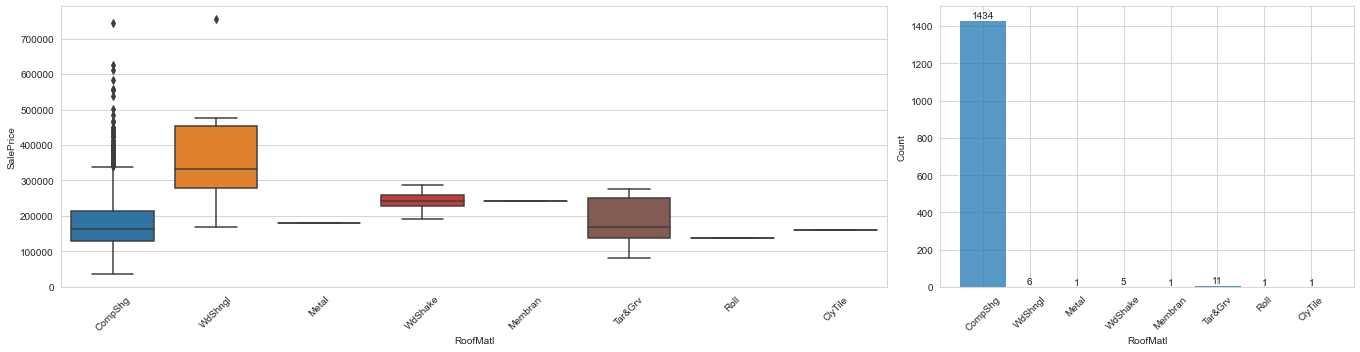

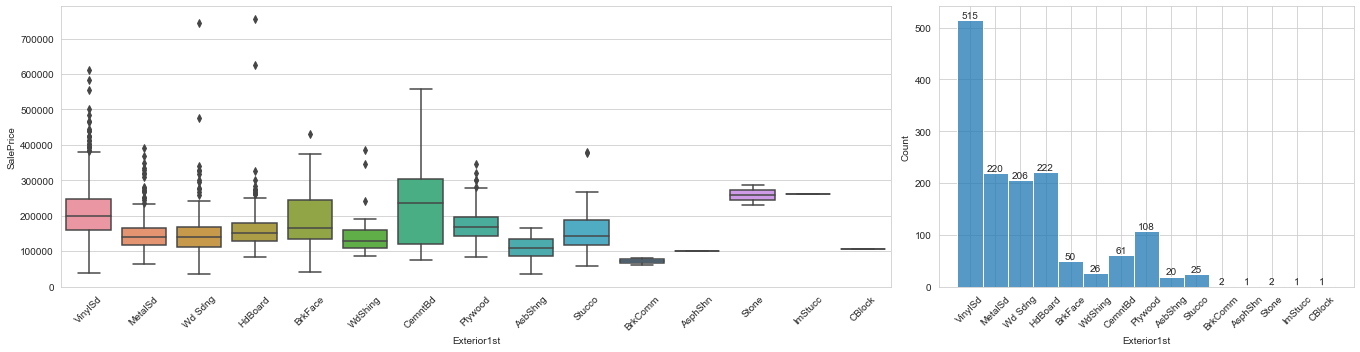

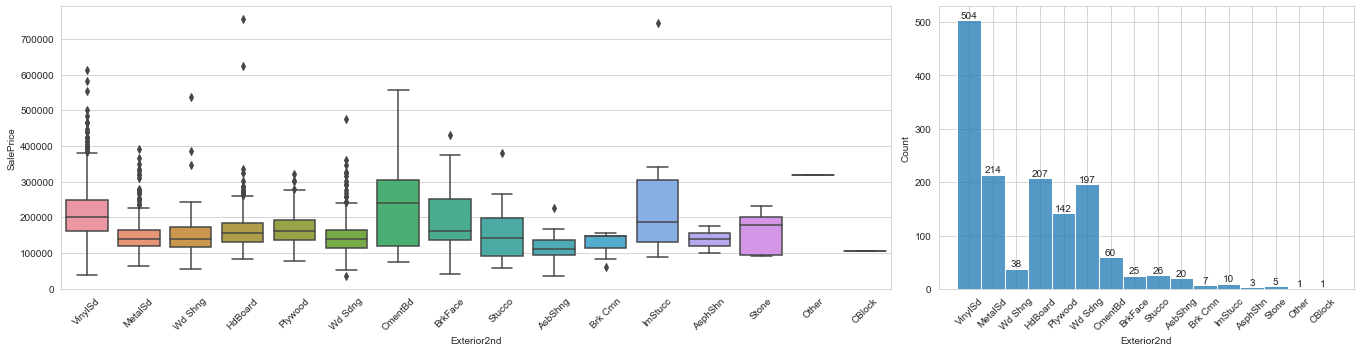

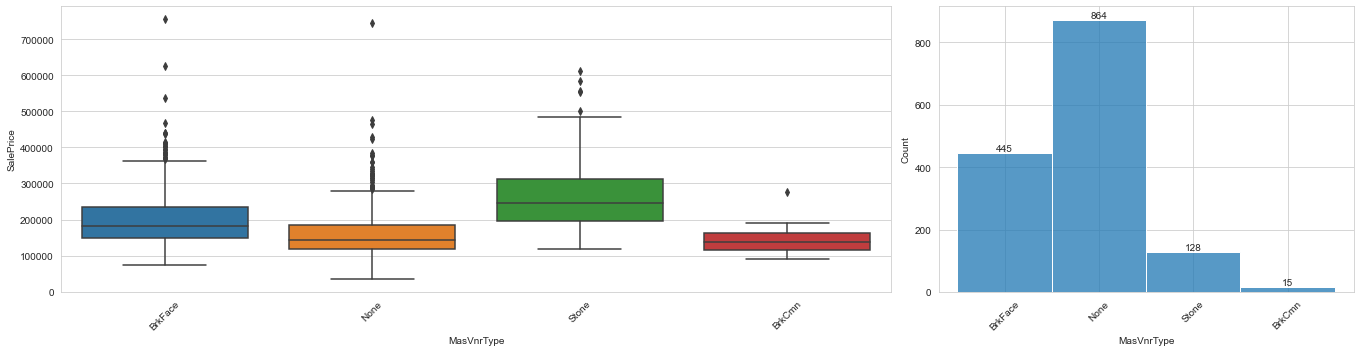

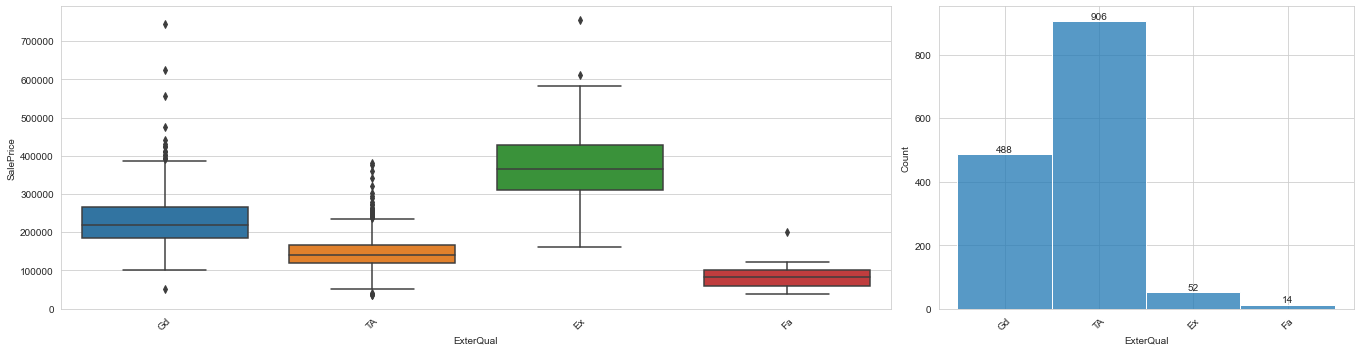

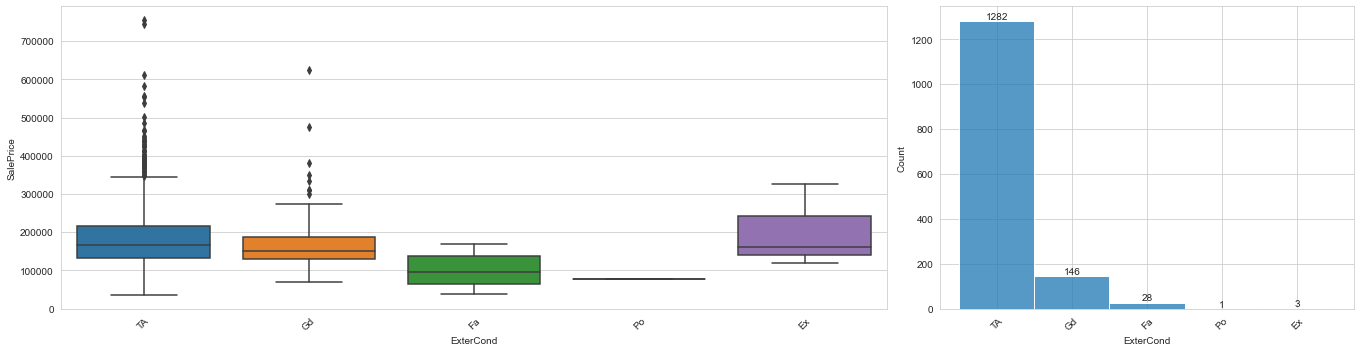

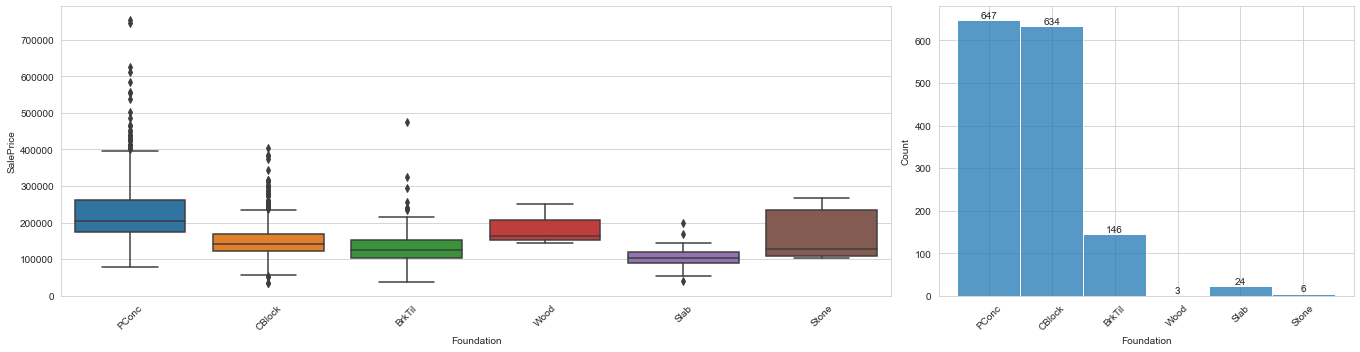

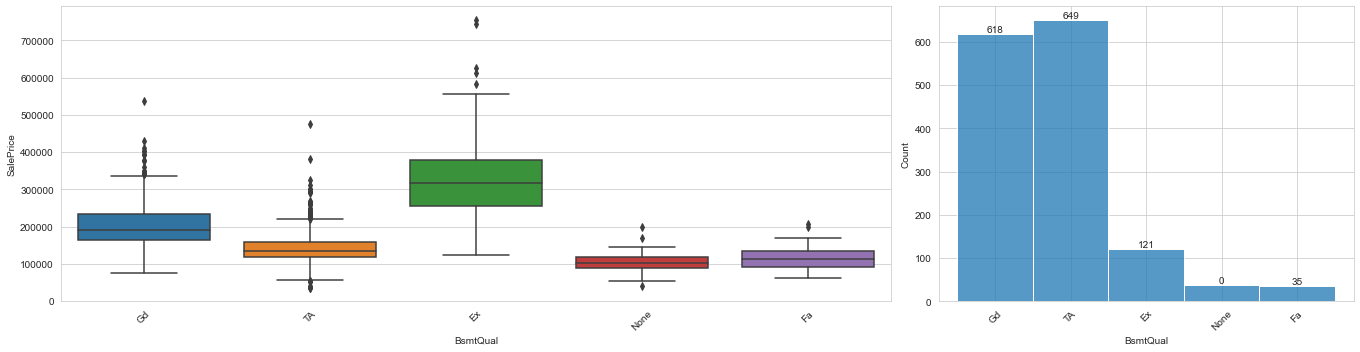

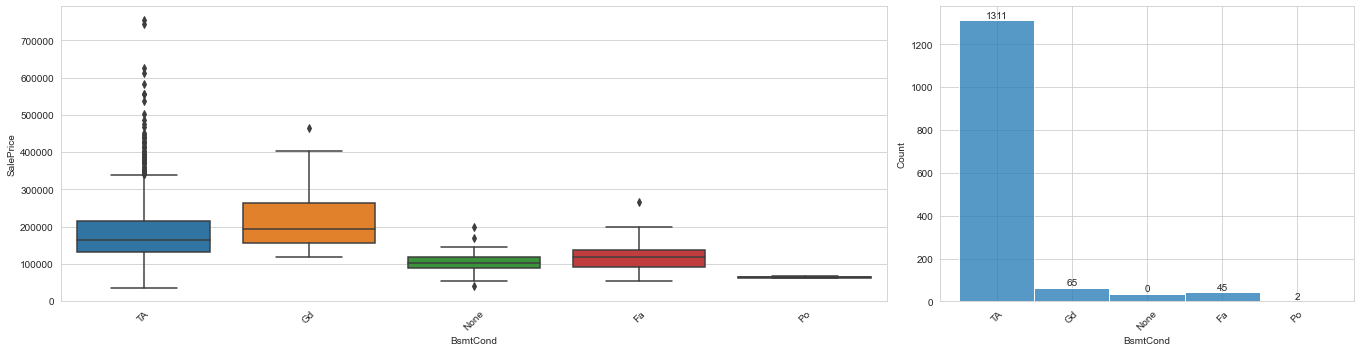

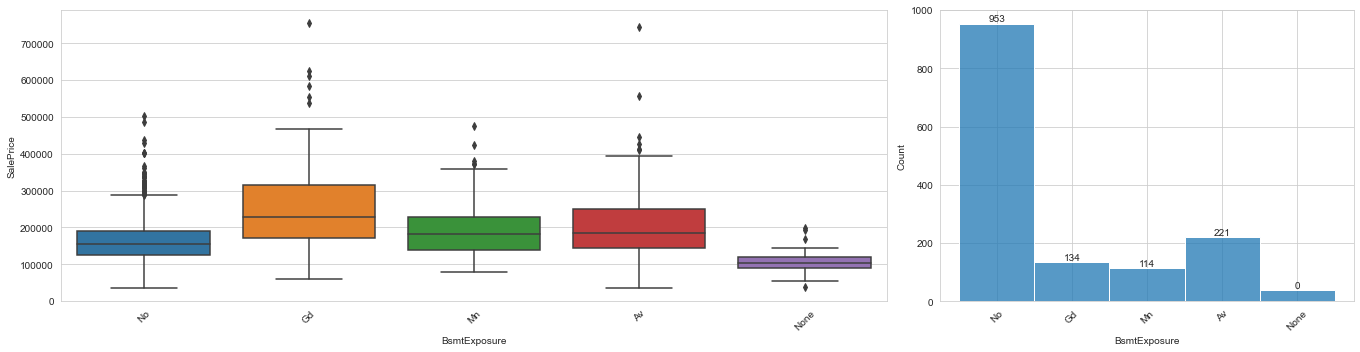

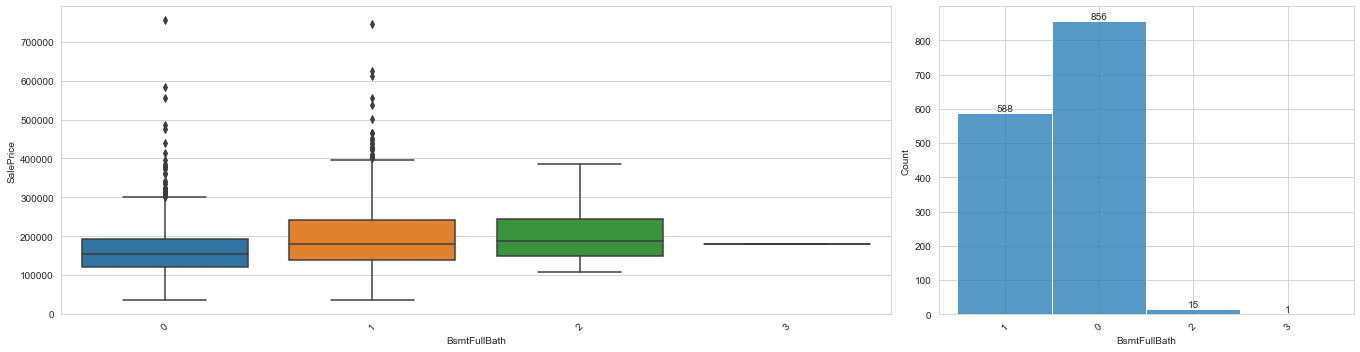

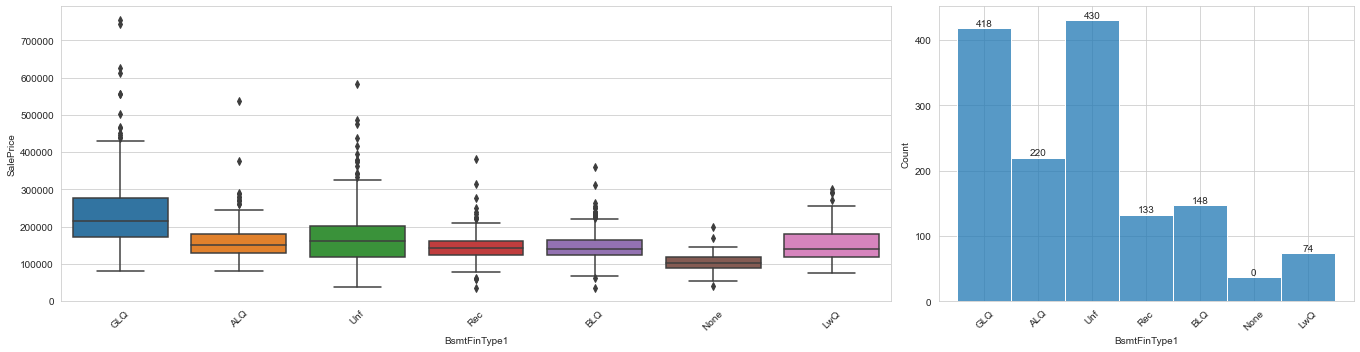

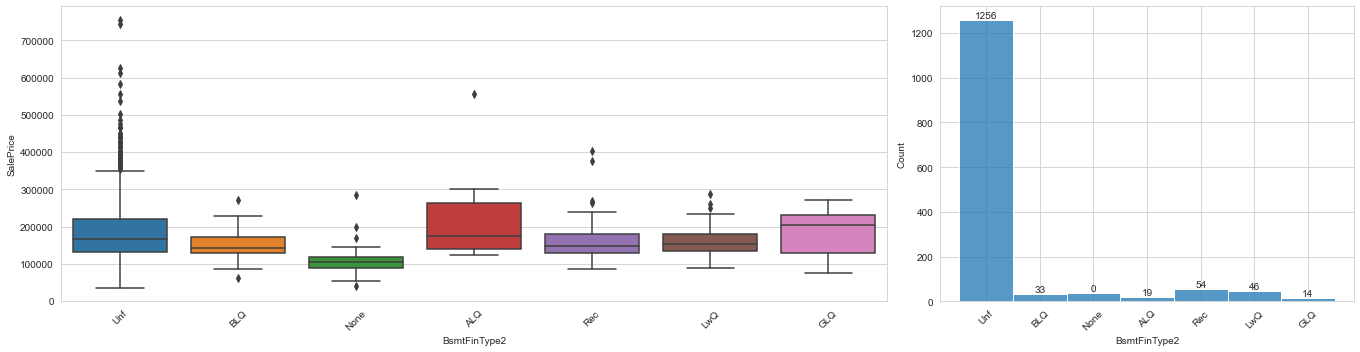

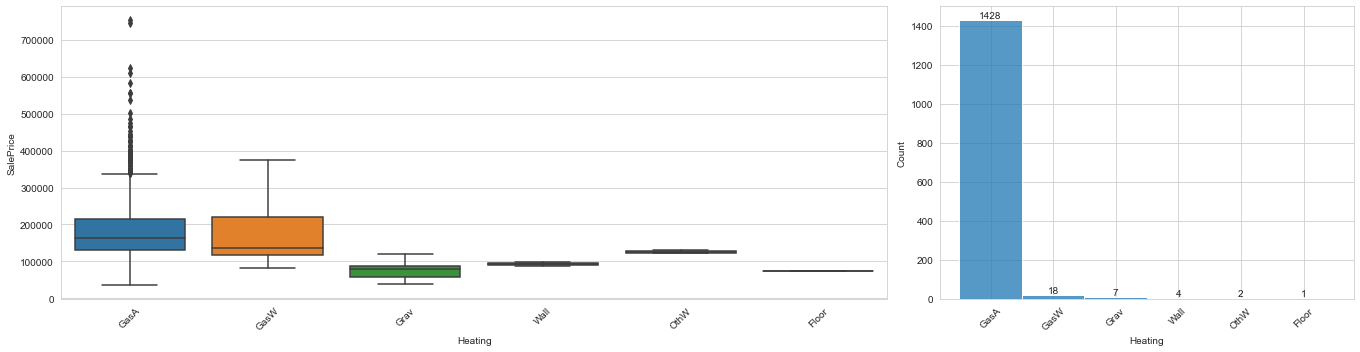

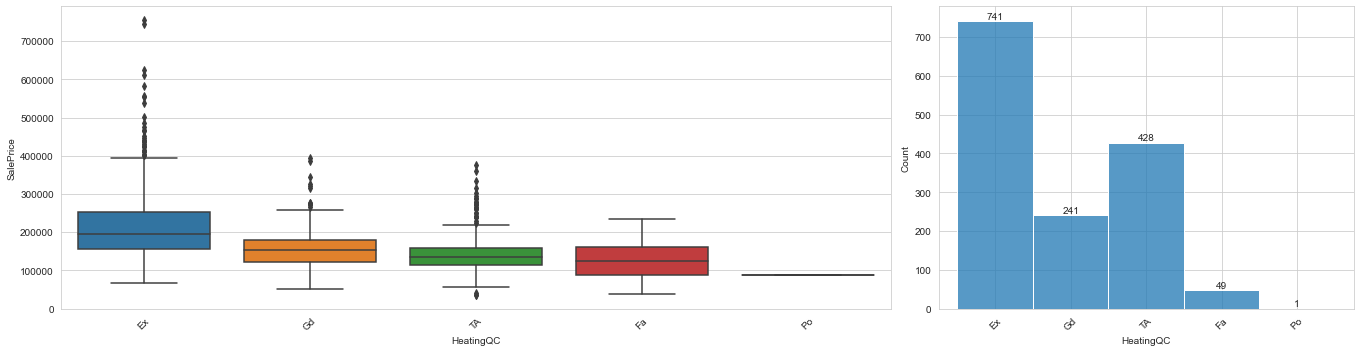

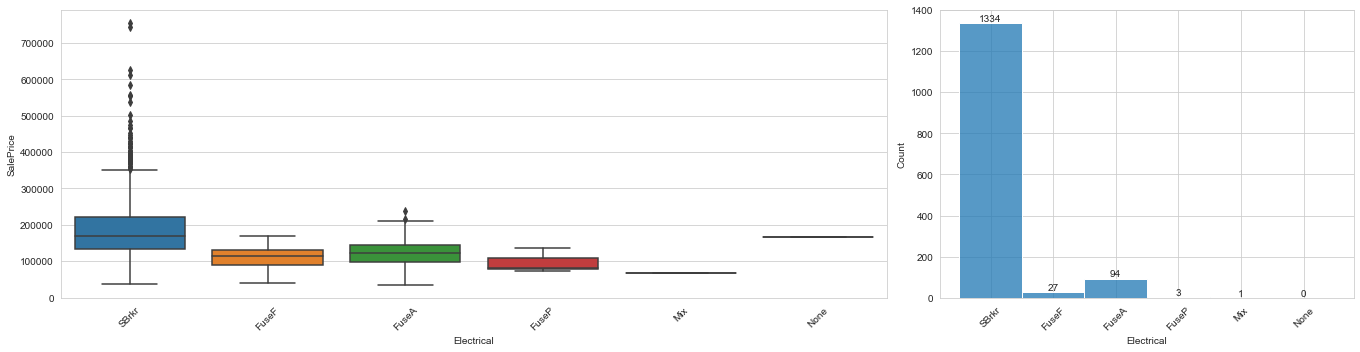

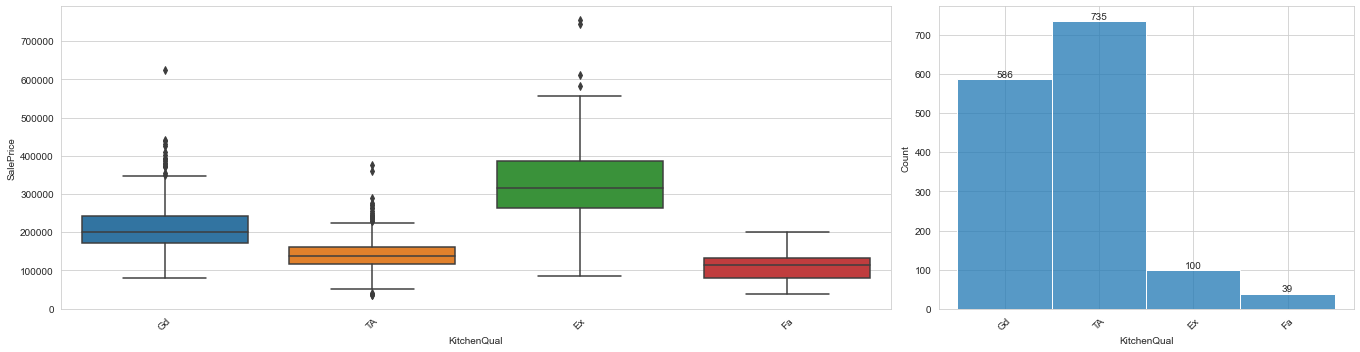

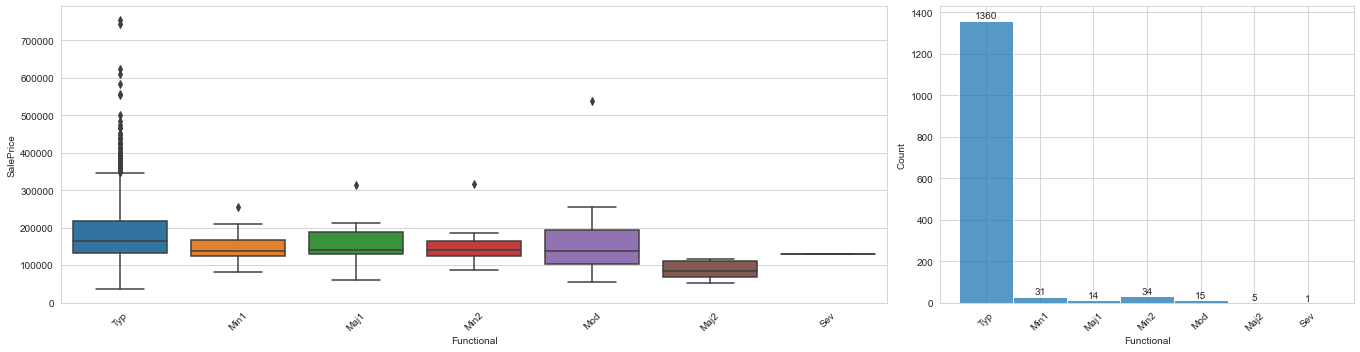

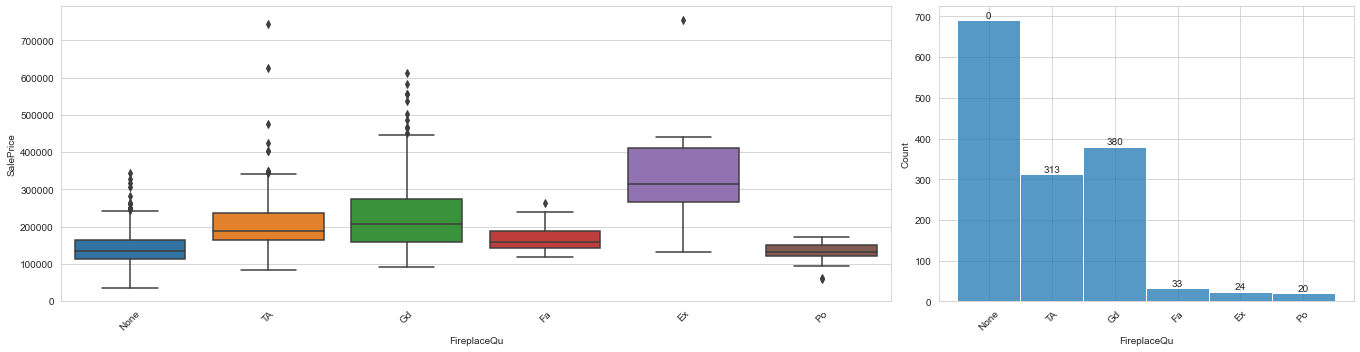

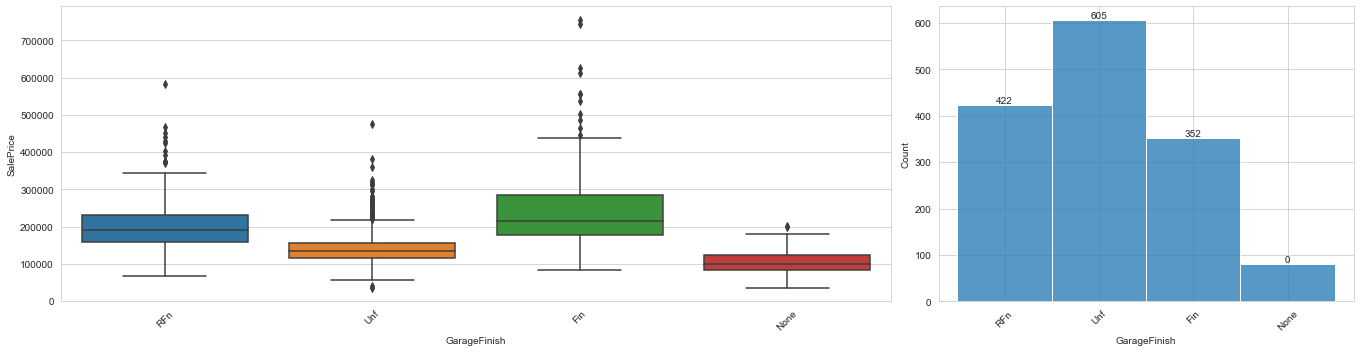

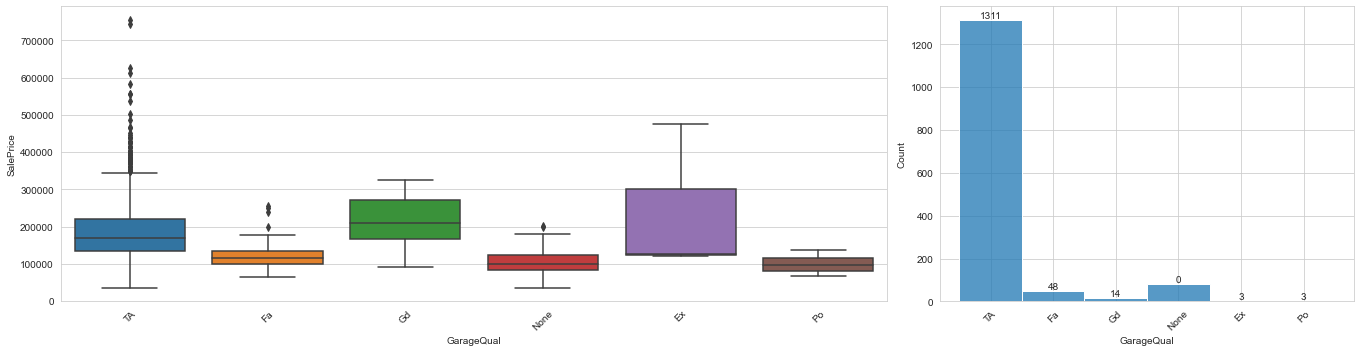

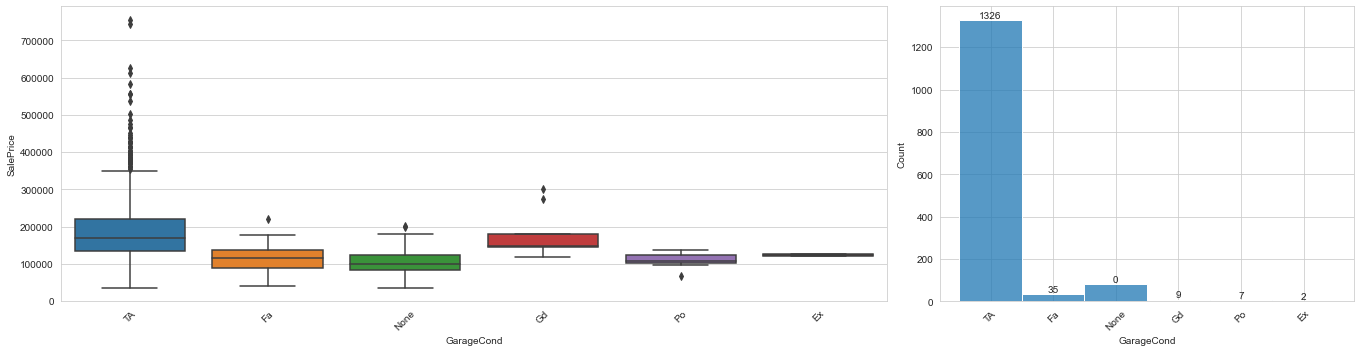

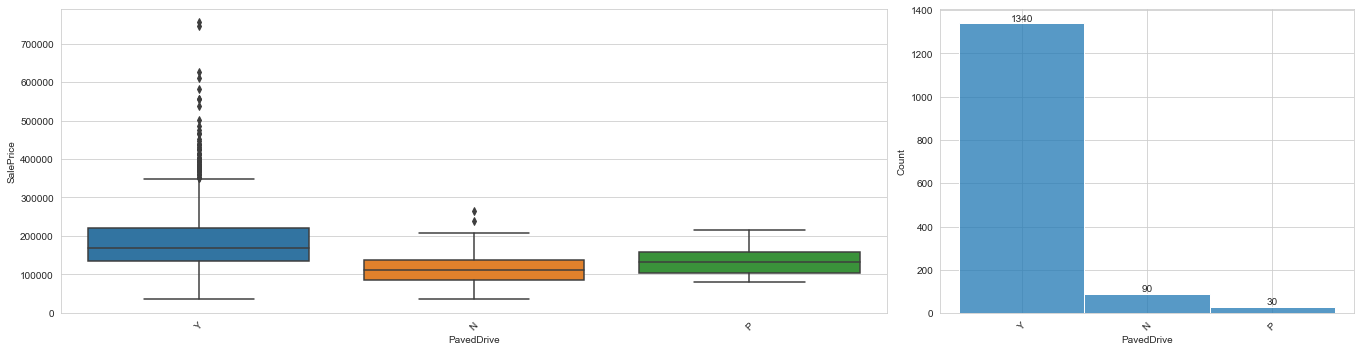

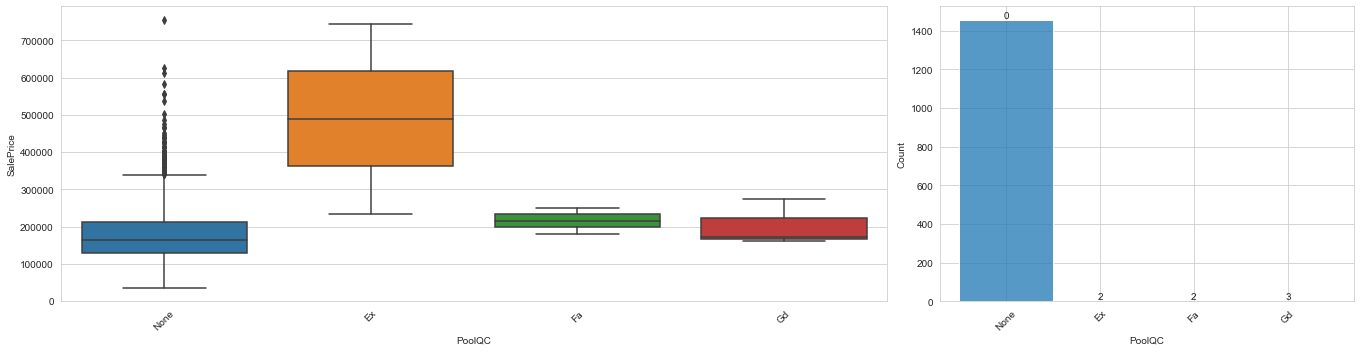

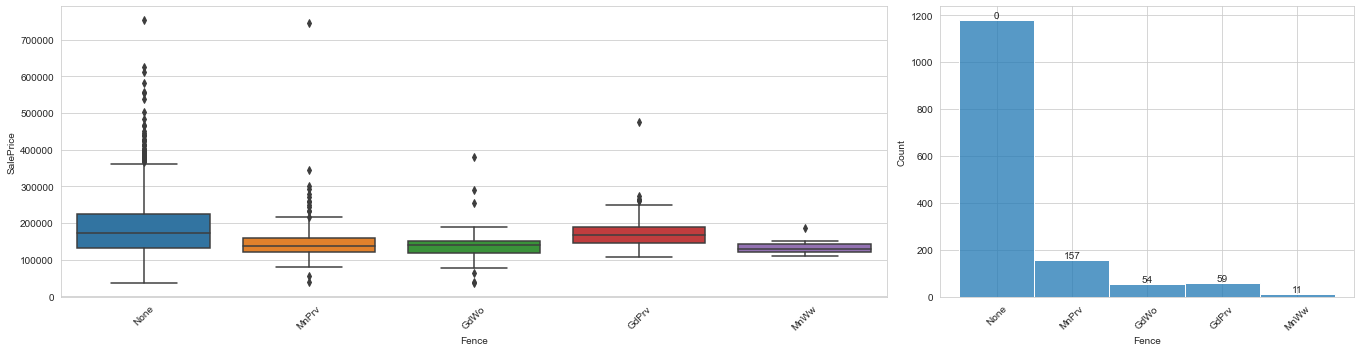

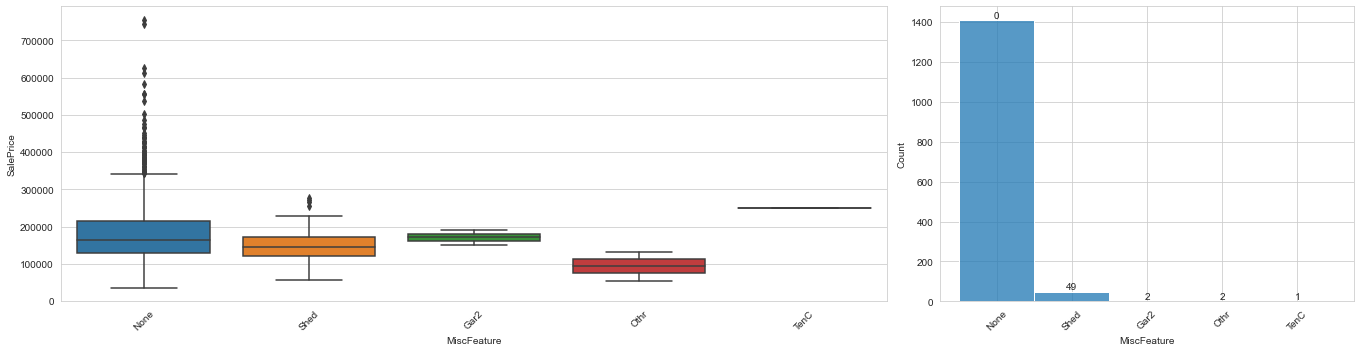

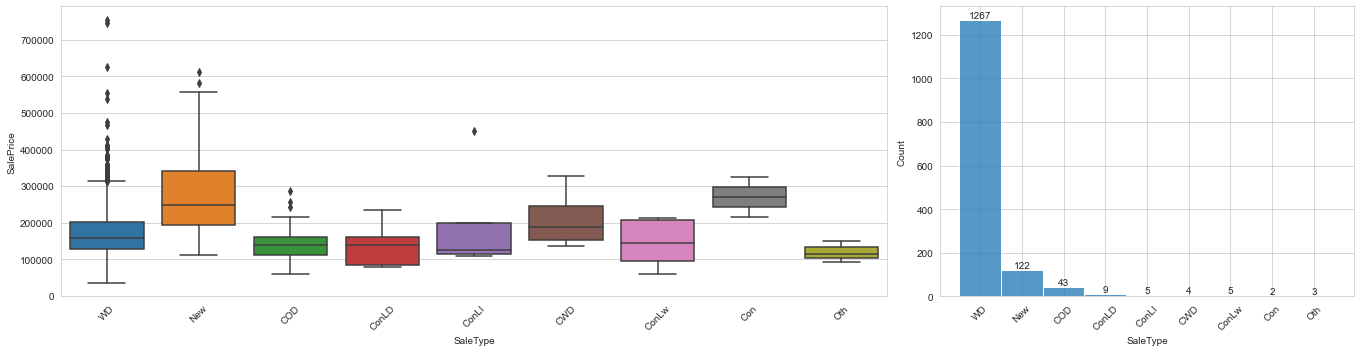

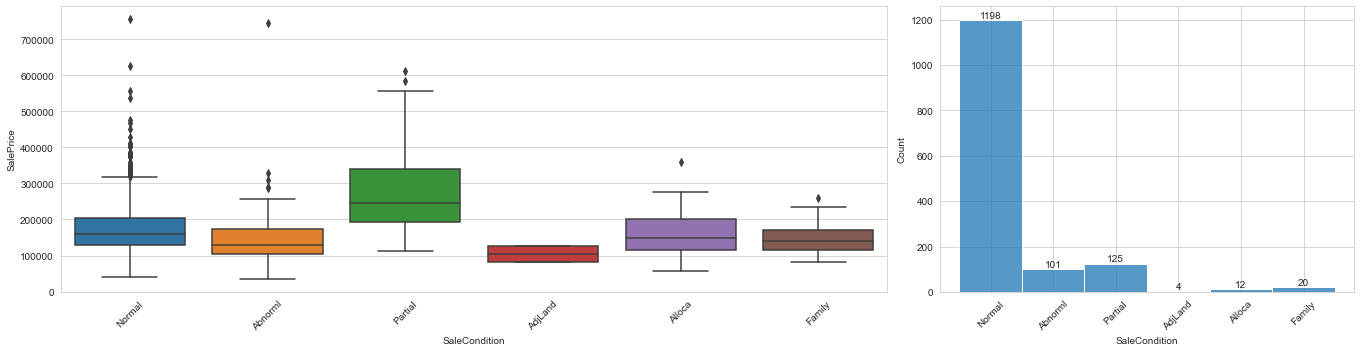

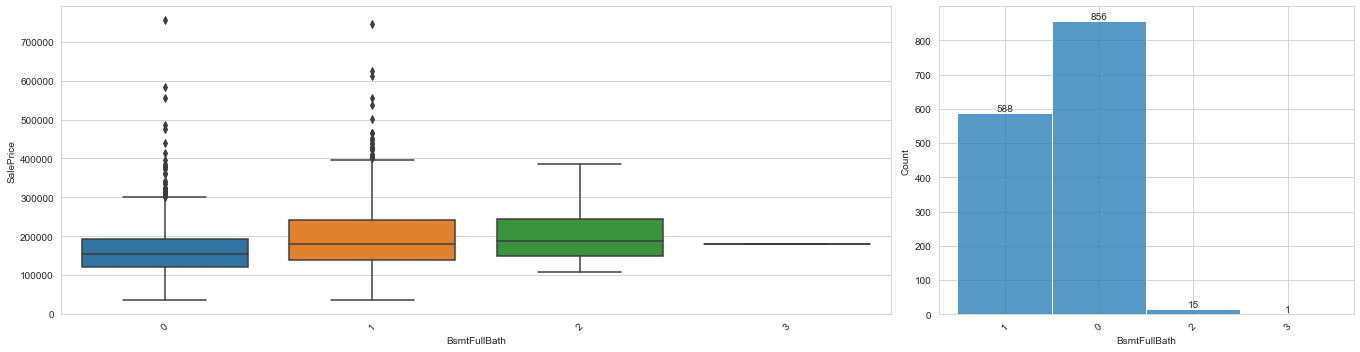

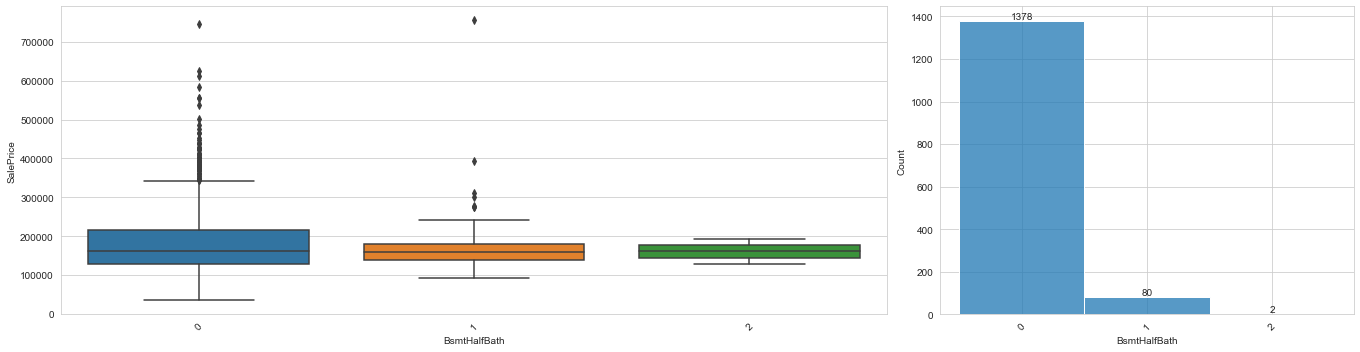

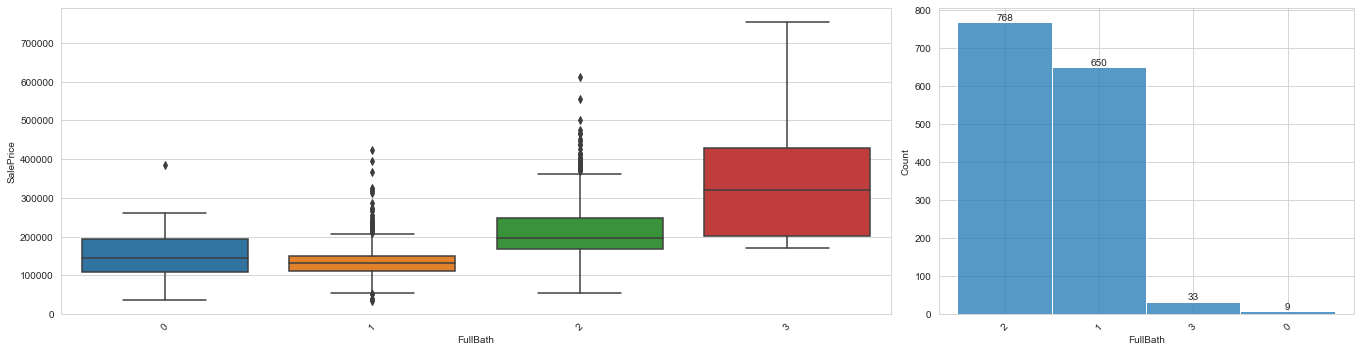

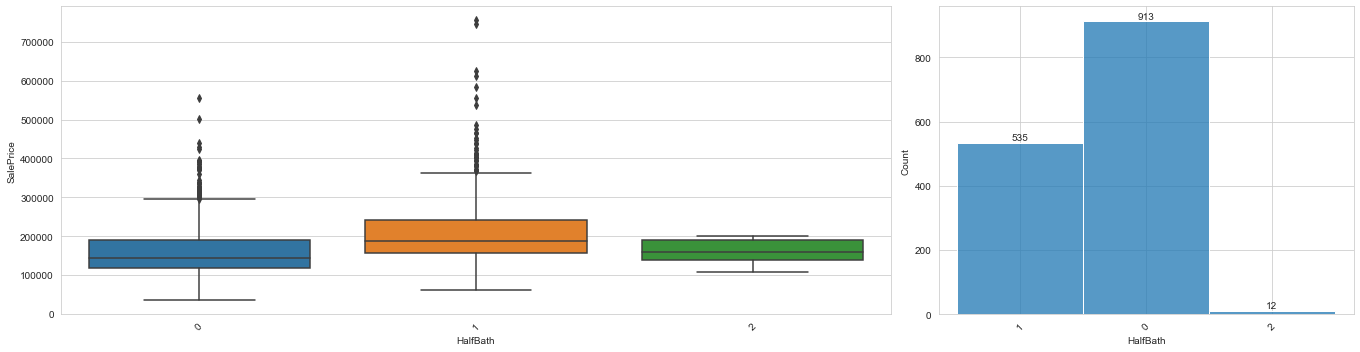

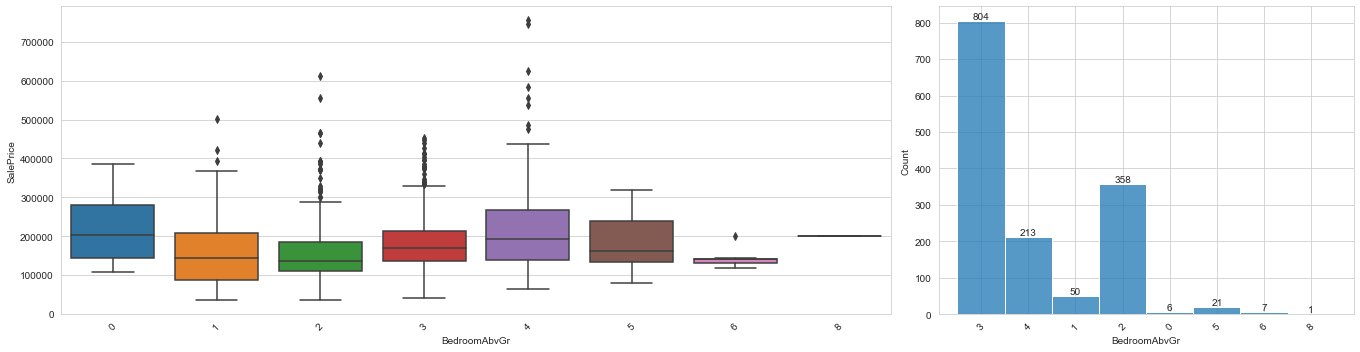

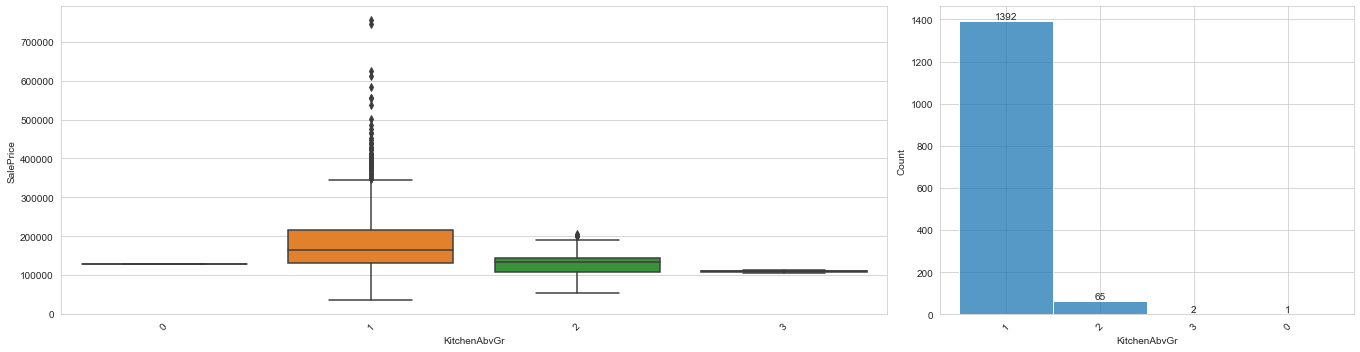

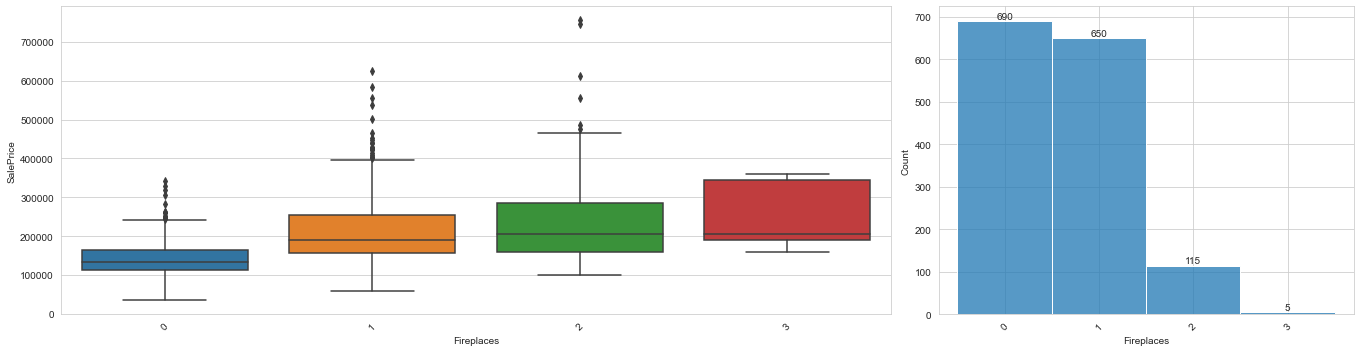

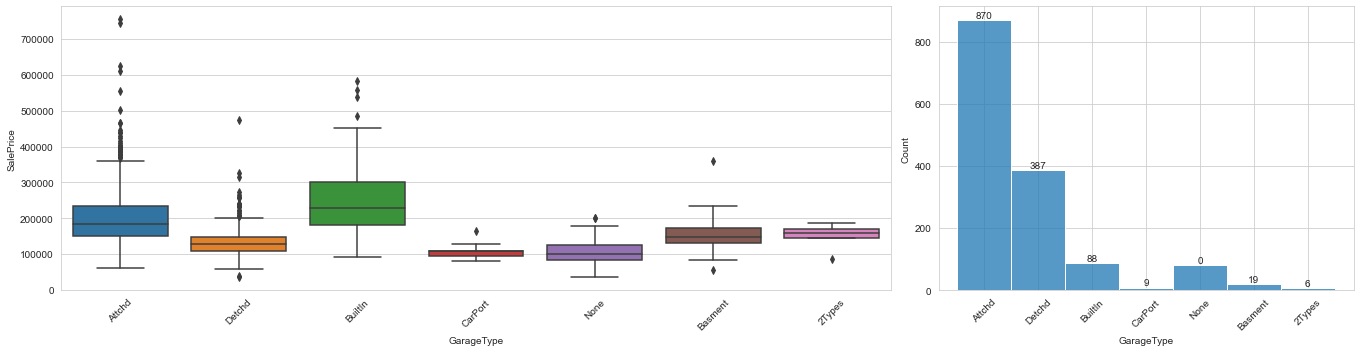

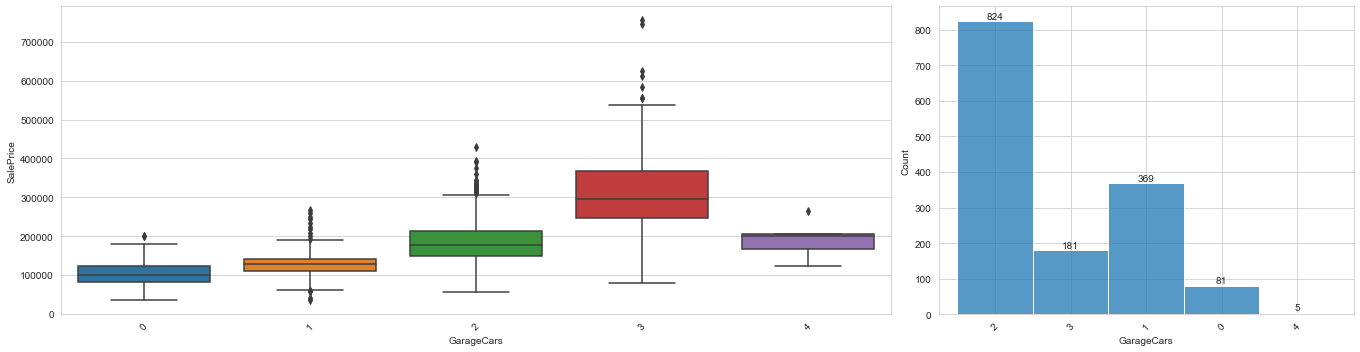

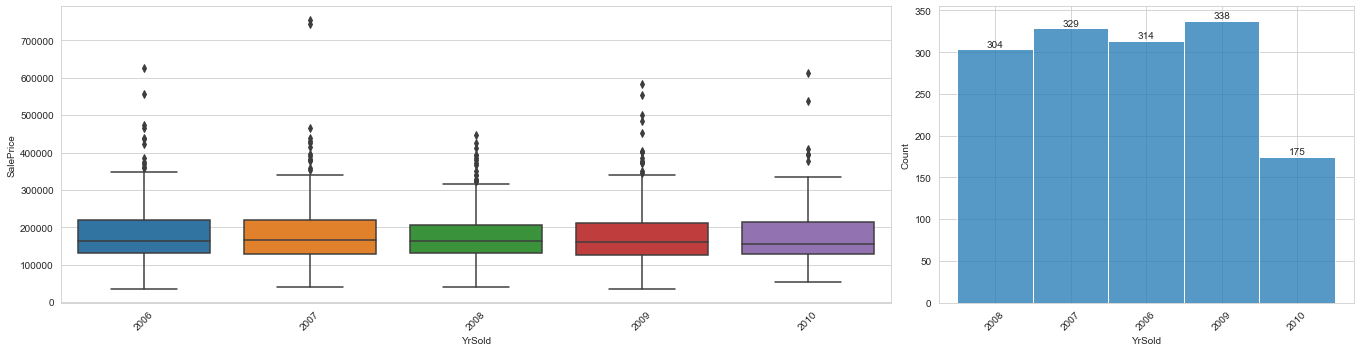

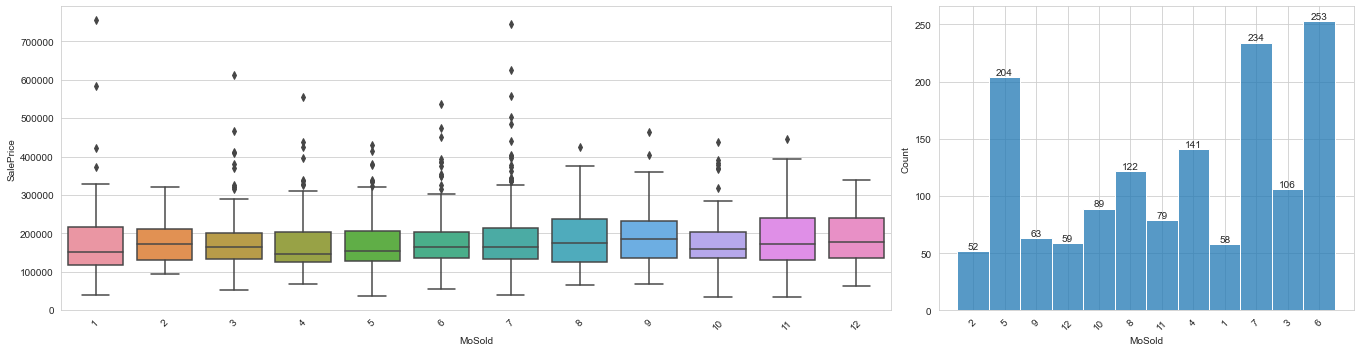

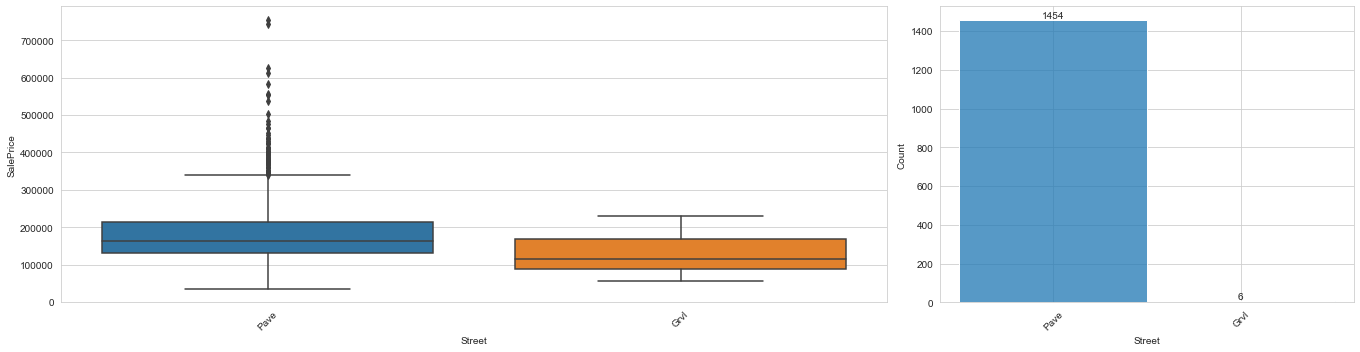

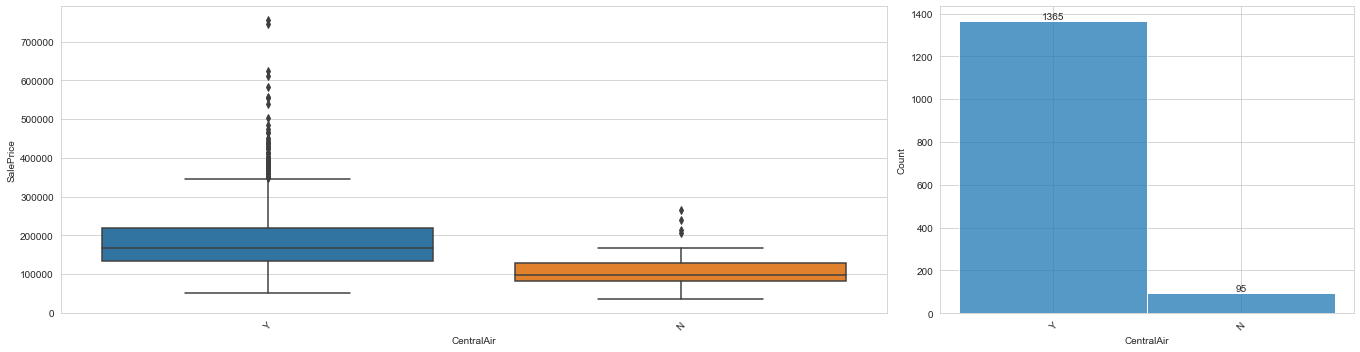

In [13]:
with sns.plotting_context(font_scale=1.8), sns.axes_style("whitegrid"):
    for cat in categorical_columns:
        plot_box_hist(cat)

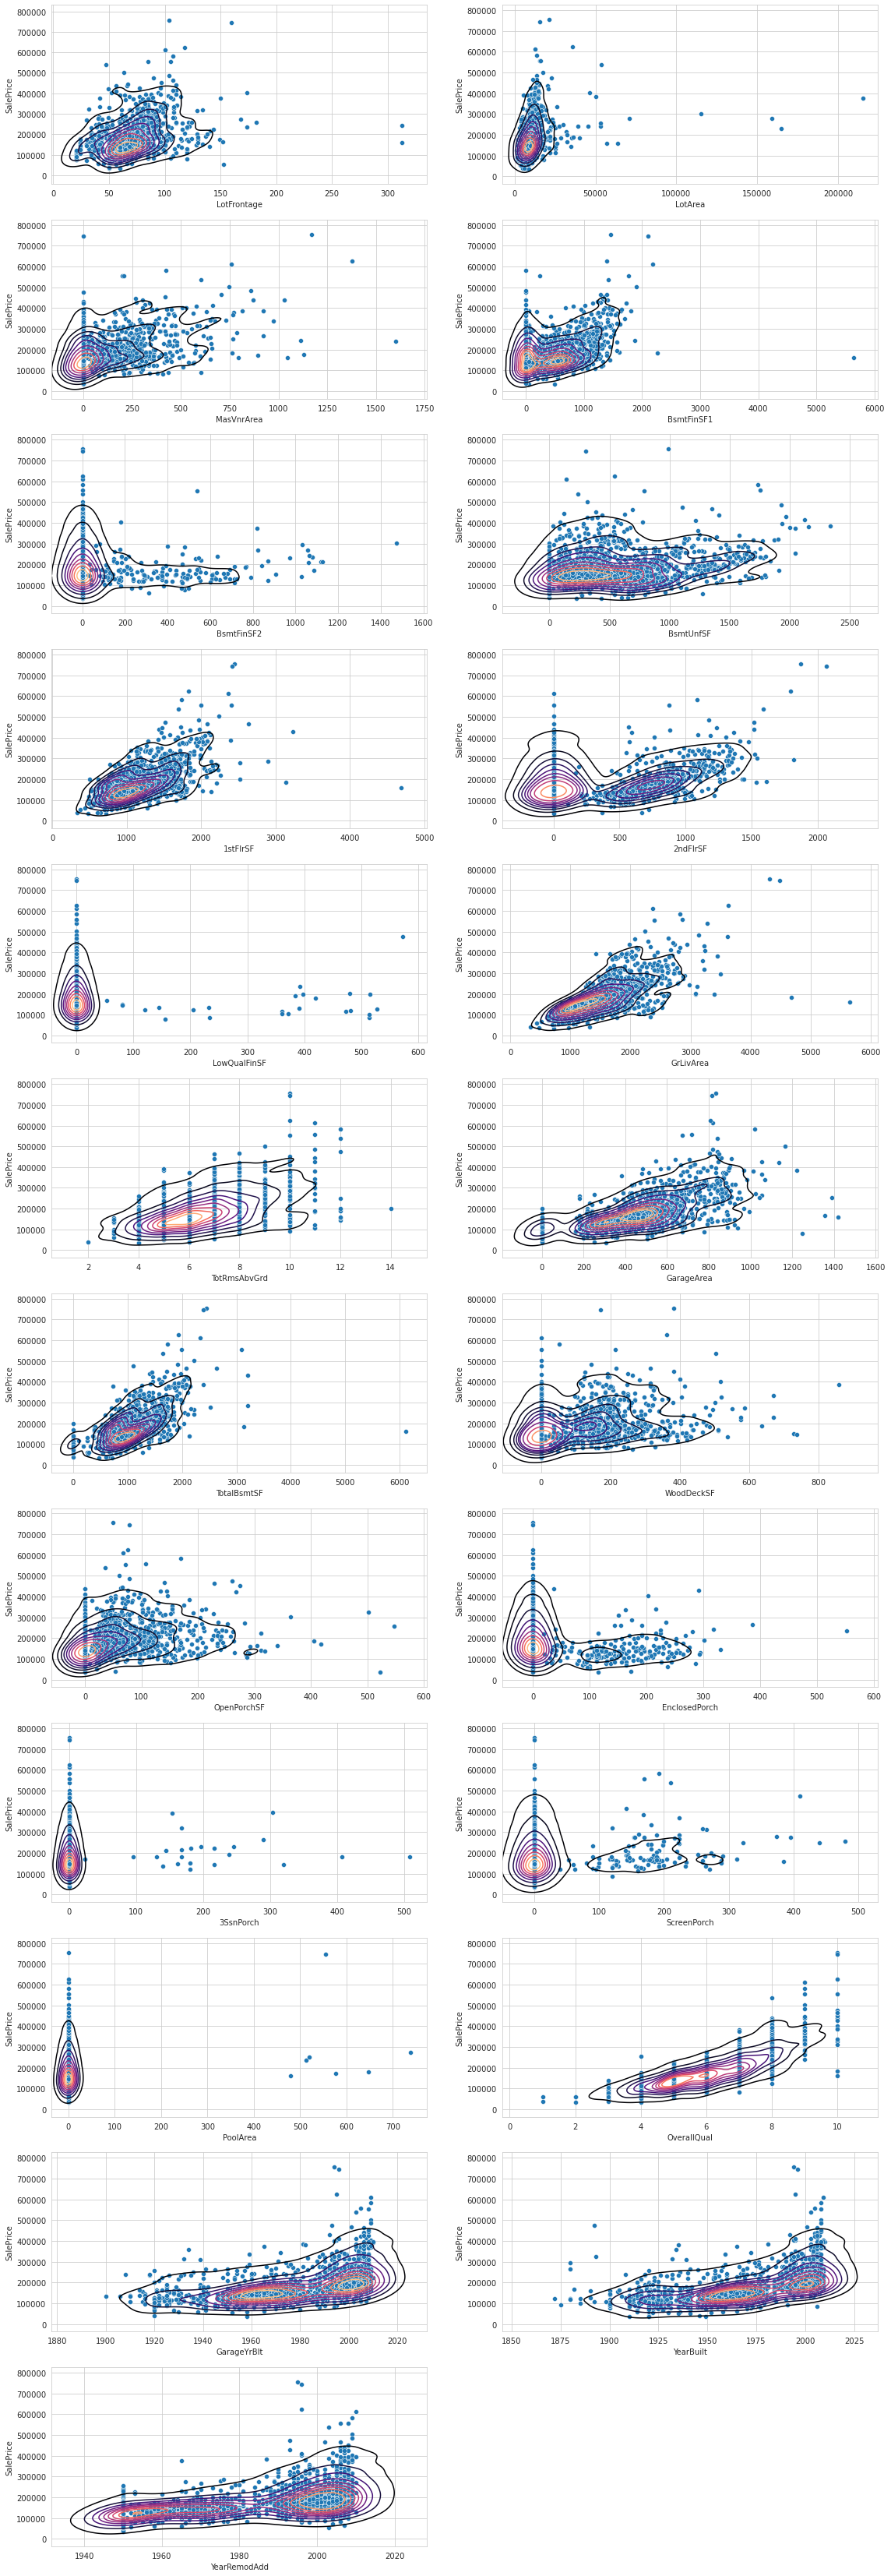

In [14]:
with sns.plotting_context(font_scale=1.5), sns.axes_style("whitegrid"):
    n = len(float_columns)
    plt.figure(figsize=(19, 5*(n+1)//2))
    for i, col in enumerate(float_columns):
        plt.subplot((n+1)//2, 2, i+1)
        sns.scatterplot(x = col, y = target_name, data = train_df, )
        sns.kdeplot(x = col, y = target_name, data = train_df, cmap = 'magma')

# Гипотезы важных признаков

В данном варианте одним из кандидатов на важный признак является возраст здания и срок его последнего кап ремонта. Эти признаки представлены ниже. Также в моделях присутствуют еще несколько группировок и агрегаций

In [15]:
train_df["AgeBuild"] = train_df["YrSold"] - train_df["YearBuilt"]
test_df["AgeBuild"] = test_df["YrSold"] - test_df["YearBuilt"]

train_df["AgeRemod"] = train_df["YrSold"] - train_df["YearRemodAdd"]
test_df["AgeRemod"] = test_df["YrSold"] - test_df["YearRemodAdd"]

float_columns.extend(["AgeBuild", "AgeRemod"])


In [16]:
important_features = [
    "AgeBuild",
    "TotalBsmtSF",
    "GrLivArea",
    "GarageArea",
    "OverallQual",
    "Neighborhood",
    "MasVnrArea",
    "OverallCond",
    "MSZoning",
]


### Корреляция Спирмана

In [17]:
for float_cat in [
    "AgeBuild",
    "TotalBsmtSF",
    "GrLivArea",
    "GarageArea",
    "OverallQual",
    "MasVnrArea",
]:
    print(
        float_cat,
        scipy.stats.spearmanr(
            train_df.loc[~train_df[float_cat].isna(), target_name],
            train_df.loc[~train_df[float_cat].isna(), float_cat],
        ),
    )


AgeBuild SpearmanrResult(correlation=-0.6501196678153068, pvalue=3.914550572021607e-176)
TotalBsmtSF SpearmanrResult(correlation=0.6027254448924096, pvalue=4.157299803636561e-145)
GrLivArea SpearmanrResult(correlation=0.7313095834659141, pvalue=1.4310154533091797e-244)
GarageArea SpearmanrResult(correlation=0.6493785338868229, pvalue=1.320918093357304e-175)
OverallQual SpearmanrResult(correlation=0.8098285862017292, pvalue=0.0)
MasVnrArea SpearmanrResult(correlation=0.4213094993288471, pvalue=1.4726128013810823e-63)


#### Вывод
p - value в данном случае говорит о том, что нулевая гипотеза о том что признаки некоррелируют может быть отвергнута для вещественных признаков

### Хи квадрат

In [18]:
bins = np.linspace(
    train_df[target_name].quantile(0.01), train_df[target_name].quantile(0.99), 7
)
overall_distr = pd.cut(train_df[target_name], bins).value_counts().sort_index()
for feature in ["Neighborhood", "OverallCond", "MSZoning"]:
    for category in train_df[feature].unique():
        neighborhood_distr = (
            pd.cut(train_df.loc[train_df[feature] == category, target_name], bins)
            .value_counts()
            .sort_index()
        )
        print(
            feature,
            category,
            scipy.stats.chisquare(neighborhood_distr, overall_distr),
        )
        # display(pd.concat((neighborhood_distr, overall_distr),axis = 1))


Neighborhood CollgCr Power_divergenceResult(statistic=1155.4156556951662, pvalue=1.332697352723716e-247)
Neighborhood Veenker Power_divergenceResult(statistic=1408.1478354461374, pvalue=2.362102736444846e-302)
Neighborhood Crawfor Power_divergenceResult(statistic=1330.3507665770524, pvalue=1.6972607875738747e-285)
Neighborhood NoRidge Power_divergenceResult(statistic=1361.238278151484, pvalue=3.447787072283095e-292)
Neighborhood Mitchel Power_divergenceResult(statistic=1334.1946573071202, pvalue=2.4942216303745085e-286)
Neighborhood Somerst Power_divergenceResult(statistic=1266.2019854504128, pvalue=1.3407080799389298e-271)
Neighborhood NWAmes Power_divergenceResult(statistic=1289.209261483866, pvalue=1.390208711099916e-276)
Neighborhood OldTown Power_divergenceResult(statistic=1227.4975429556175, pvalue=3.248673063860367e-263)
Neighborhood BrkSide Power_divergenceResult(statistic=1323.2619298409682, pvalue=5.829007844395845e-284)
Neighborhood Sawyer Power_divergenceResult(statistic=12

#### Вывод
Для категориальных переменных также видно, отвержение гипотезы о равномерном распрделении целевой переменной

### Визуализация совместного распределения признаков

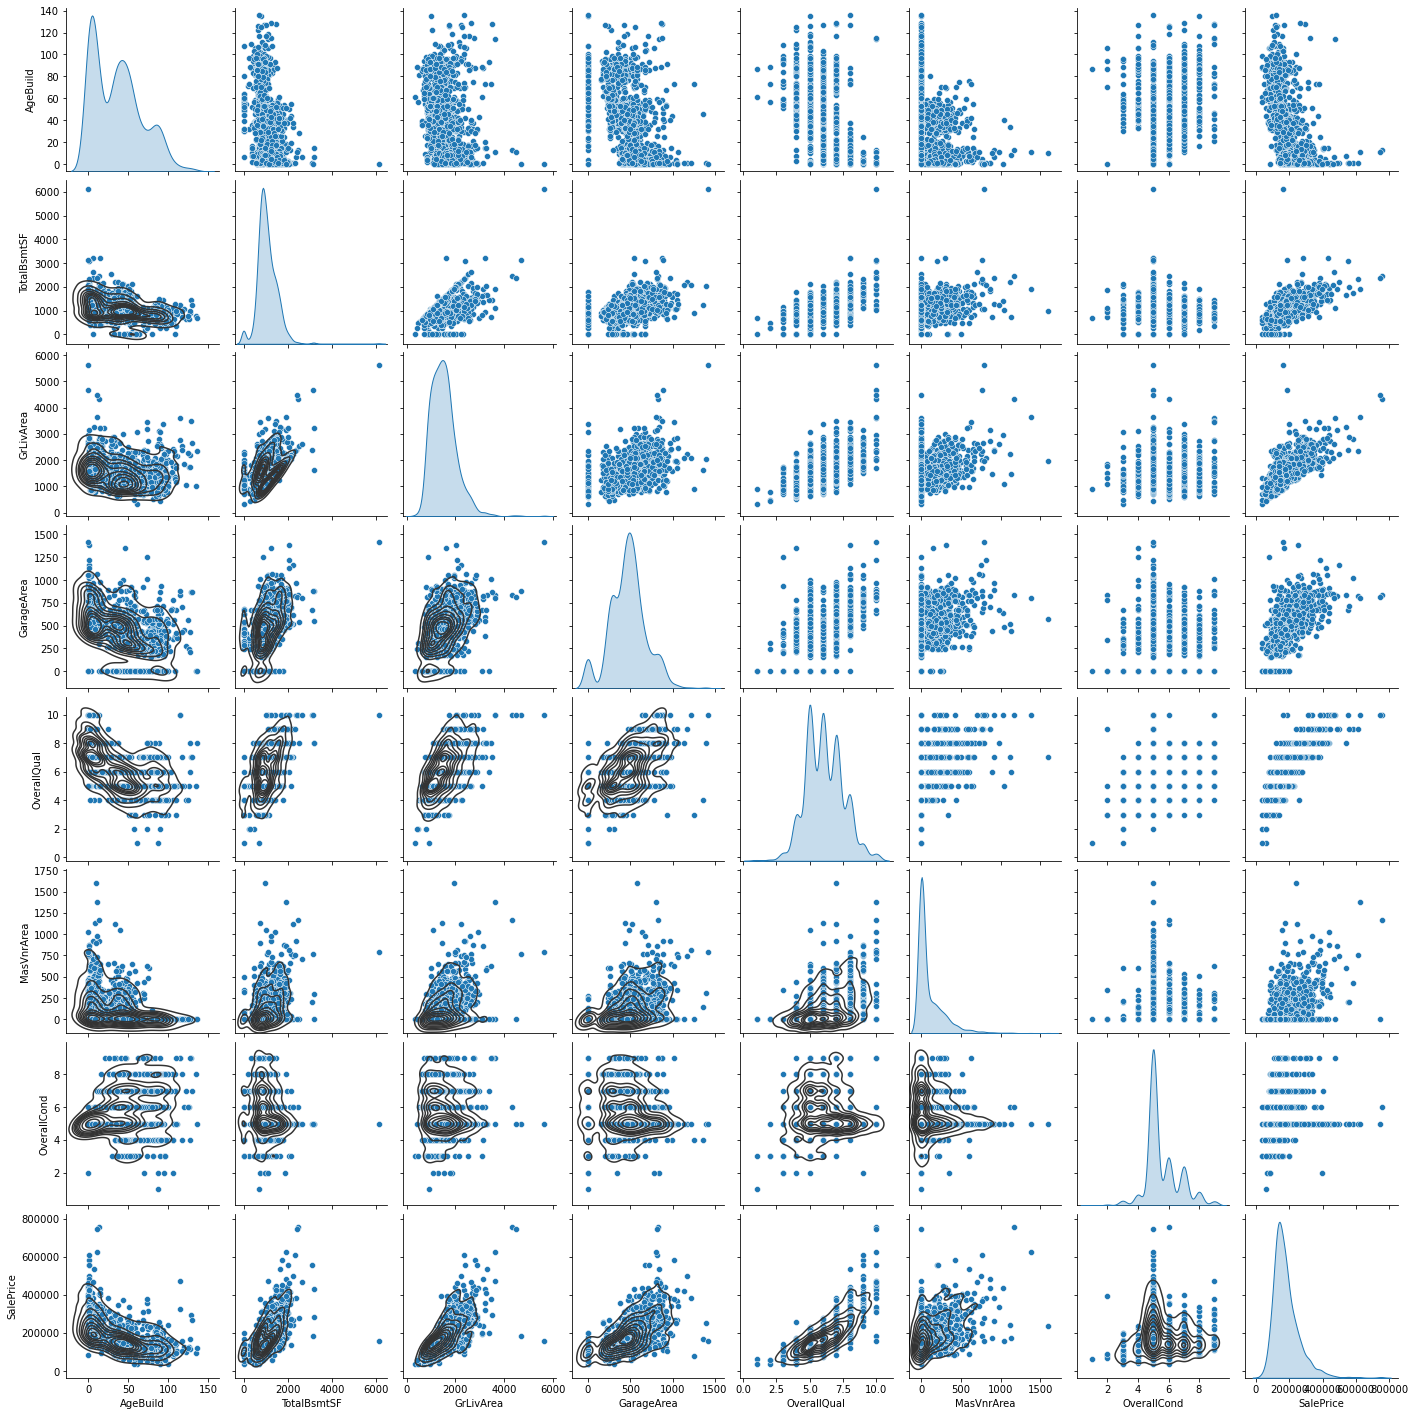

In [19]:
g = sns.pairplot(train_df[important_features+ [target_name]], diag_kind="kde")
g.map_lower(sns.kdeplot, levels=10, color=".2")


# Разделение на тестовую и валидационную выборку

In [20]:
train_X, val_X, train_y, val_y = sklearn.model_selection.train_test_split(
    train_df[~train_df['SalePrice'].isna()].drop(columns =  ['Id',target_name]),
    train_df[~train_df['SalePrice'].isna()][target_name],
    test_size = 0.2,
    shuffle = True,
    random_state=2021
)

<AxesSubplot:xlabel='SalePrice', ylabel='Density'>

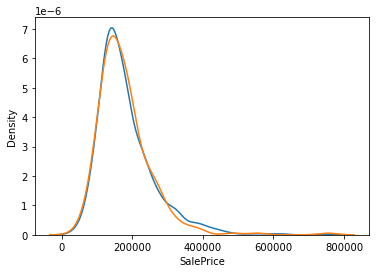

In [21]:
sns.kdeplot(train_y)
sns.kdeplot(val_y)

Из графика наглядно видно, что данные на валидационной и обучающей выборке  распределены одинаков

# Обучение различных моделей

## Random Forest и CatBoost, используя признаки с высокой корреляцией Спирмана, RF с OHE


In [22]:
data = train_df.copy()

new_clm = []
clm_nan = []
for i in data.columns:
    if data[i].count() > 1200:
        new_clm.append(i)
        if data[i].count() < 1460:
            clm_nan.append(i)
data = data[new_clm]  # убираем столбцы, где много пропусков

train_features = []
for clm in data.columns:
    if clm == "SalePrice":
        continue
    stat = sps.spearmanr(data["SalePrice"], data[clm])[0]
    if abs(stat) > 0.3:
        train_features.append(clm)


In [23]:
def remove_outliers(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    return df[(df[col] > (Q1 - 1.5 * IQR)) & (df[col] < (Q3 + 1.5 * IQR))]

data = remove_outliers(data, "SalePrice")

In [24]:
s = [
    "MSZoning",
    "LotShape",
    "Foundation",
    "HeatingQC",
    "CentralAir",
    "SaleCondition",
    "ExterQual",
    "KitchenQual",
]

data_for_rf = data[train_features].drop(columns=s)

train_X, test_X, train_y, test_y = sklearn.model_selection.train_test_split(
    data_for_rf, data["SalePrice"], train_size=0.8, random_state=2021
)


In [25]:
data_for_rf = data[train_features].drop(columns = s)

train_X, test_X , train_y, test_y = sklearn.model_selection.train_test_split(
    data_for_rf,
    data['SalePrice'],
    train_size=0.8,
    random_state=2021
)


In [26]:
reg_rf = RandomForestRegressor(criterion = 'mse')
reg_rf.fit(train_X, train_y)

res = reg_rf.predict(test_X)
math.sqrt(sklearn.metrics.mean_squared_log_error(res, test_y))

0.1384733886185875

In [27]:
scores = cross_val_score(
    reg_rf, train_X, train_y, cv=5, scoring="neg_mean_squared_log_error"
)
np.sqrt(-scores)


array([0.122138  , 0.16272018, 0.13547295, 0.14468233, 0.16446632])

In [28]:
important_features = [i for i in zip(data_for_rf.columns, reg_rf.feature_importances_)]
sorted(important_features, key = lambda p: -p[1])

[('OverallQual', 0.5259514198992015),
 ('GrLivArea', 0.14887055644701283),
 ('TotalBsmtSF', 0.06881121311200881),
 ('GarageArea', 0.050867751823203536),
 ('BsmtFinSF1', 0.03588186623705509),
 ('LotArea', 0.028584660826088484),
 ('1stFlrSF', 0.025110390102683754),
 ('YearBuilt', 0.019296425651565512),
 ('AgeBuild', 0.018611854645004818),
 ('AgeRemod', 0.01376713009141593),
 ('GarageCars', 0.012465786654955766),
 ('Fireplaces', 0.011579429126548402),
 ('YearRemodAdd', 0.011081120562570938),
 ('OpenPorchSF', 0.009923808726227142),
 ('WoodDeckSF', 0.009216583097101676),
 ('TotRmsAbvGrd', 0.004499441214714313),
 ('FullBath', 0.0029485586747892262),
 ('HalfBath', 0.0025320031078523678)]

In [29]:
train_features_for_catboost = train_features.copy()

#добавляем признаки, которые не были взяты Спирманом
#но по графикам кажутся полезными
train_features_for_catboost.append('Neighborhood')
train_features_for_catboost.append('OverallCond')
train_features_for_catboost.append('PavedDrive')


In [30]:
data_1 = data[train_features_for_catboost]
data_1.loc[:, "SalePrice"] = data.loc[:, "SalePrice"]

cat_features = [
    "MSZoning",
    "LotShape",
    "Foundation",
    "HeatingQC",
    "CentralAir",
    "SaleCondition",
    "ExterQual",
    "KitchenQual",
]  # >0.3

# некоторые числовые значения лучше рассматривать как категориальные
int_cat_features = ["HalfBath", "OverallCond"]

additional_cat_features = ["Neighborhood", "PavedDrive"]
cat_features.extend(int_cat_features + additional_cat_features)



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [31]:
train_X, test_X, train_y, test_y = sklearn.model_selection.train_test_split(
    data_1[train_features_for_catboost],
    data_1["SalePrice"],
    train_size=0.8,
    random_state=2021,
)

train_pool = catboost.Pool(train_X, label=train_y, cat_features=cat_features)
val_pool = catboost.Pool(test_X, label=test_y, cat_features=cat_features)
test_pool = catboost.Pool(test_X, label=test_y, cat_features=cat_features)


In [32]:
?catboost.CatBoostRegressor
!rm -rf 'catboost_pricing1/snapshot.bkp'
catboost_train_dir = 'catboost_pricing1'
reg = catboost.CatBoostRegressor(
    od_pval=0.01,
    od_wait=20,
    random_seed=2021,
    train_dir=catboost_train_dir,
    task_type='CPU',
    max_ctr_complexity=4,
    use_best_model=True
)
reg.fit(
    train_pool, 
    eval_set=val_pool,
    plot=True,
    save_snapshot=True,
    snapshot_file='snapshot.bkp',
)   

"rm" ­Ґ пў«пҐвбп ў­гваҐ­­Ґ© Ё«Ё ў­Ґи­Ґ©
Є®¬ ­¤®©, ЁбЇ®«­пҐ¬®© Їа®Ја ¬¬®© Ё«Ё Ї ЄҐв­л¬ д ©«®¬.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.047067

bestTest = 18711.82025
bestIteration = 990

Shrink model to first 991 iterations.


In [33]:
math.sqrt(sklearn.metrics.mean_squared_log_error(reg.predict(test_X), test_y))

0.11760914695655846

Processing trees...
128/991 trees processed	passed time: 82.2ms	remaining time: 554ms
991/991 trees processed	passed time: 657ms	remaining time: 0us
Processing documents...
128/1119 documents processed	passed time: 8.36ms	remaining time: 64.7ms
1119/1119 documents processed	passed time: 75.5ms	remaining time: 0us


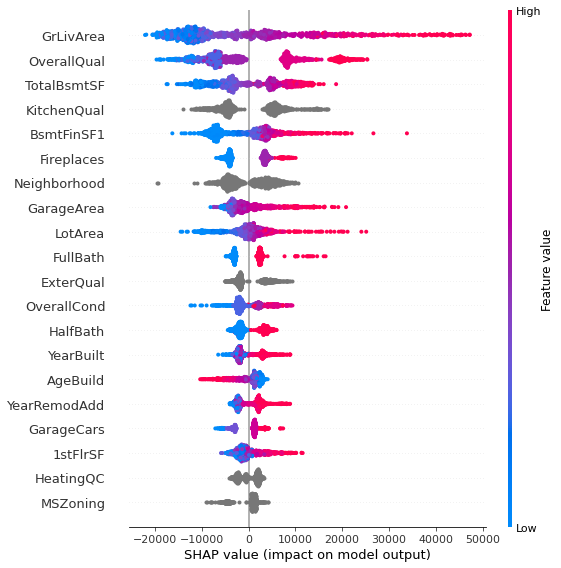

In [34]:
shap_info = reg.get_feature_importance(
    data=train_pool, 
    type='ShapValues', 
    verbose=10000
)
shap_values = shap_info[:,:-1]
base_values = shap_info[:,-1]
shap.summary_plot(shap_values, train_X)

In [35]:
train_df_with_ohe = train_df.copy()
train_features_with_ohe = []
# skip_features = ['OverallQual']
for feature in cat_features:
    # if feature in skip_features: continue
    enc = sklearn.preprocessing.OneHotEncoder(handle_unknown="ignore")
    enc.fit(train_df[feature].unique().reshape(-1, 1))
    list_of_columns = []
    for cat in enc.categories_[0]:
        list_of_columns.append(feature + "_" + str(cat))
    train_features_with_ohe.extend(list_of_columns)
    train_df_with_ohe[list_of_columns] = (
        enc.transform(train_df[feature].values.reshape(-1, 1)).toarray().astype("int")
    )
train_features_for_rf = train_features.copy()
train_features_for_rf.extend(train_features_with_ohe)


In [36]:

train_df_with_ohe = remove_outliers(train_df_with_ohe, 'SalePrice')
train_df_with_ohe = remove_outliers(train_df_with_ohe, 'LotArea')
train_df_with_ohe = remove_outliers(train_df_with_ohe, 'GrLivArea')
train_df_with_ohe = remove_outliers(train_df_with_ohe, 'TotalBsmtSF')
columns_of_df_with_ohe = train_df_with_ohe[train_features_for_rf].drop(columns = s).columns

In [37]:
train_X, test_X , train_y, test_y = sklearn.model_selection.train_test_split(
    train_df_with_ohe[train_features_for_rf].drop(columns = s),
    train_df_with_ohe['SalePrice'],
    train_size=0.8,
    random_state=2021
)

reg_rf_with_ohe = RandomForestRegressor(criterion = 'mae')
reg_rf_with_ohe.fit(train_X, train_y)

res = reg_rf_with_ohe.predict(test_X)
math.sqrt(sklearn.metrics.mean_squared_log_error(res, test_y))

0.13435184302609182

In [38]:
scores = cross_val_score(reg_rf_with_ohe, train_X, train_y, cv=5, scoring='neg_mean_squared_log_error')
np.sqrt(-scores).mean()

0.1339286424894394

In [39]:
data_test = test_df.copy()
data_test['MSZoning'] = data_test['MSZoning'].fillna(str(random.randint(0, 10)))
data_test['KitchenQual'] = data_test['KitchenQual'].fillna(str(random.randint(0, 10)))
data_test['BsmtFinSF1'] = data_test['BsmtFinSF1'].fillna(int(data_test['BsmtFinSF1'].mean())).astype('int64')
data_test['TotalBsmtSF'] = data_test['TotalBsmtSF'].fillna(int(data_test['TotalBsmtSF'].mean())).astype('int64')
data_test['GarageCars'] = data_test['GarageCars'].fillna(int(data_test['GarageCars'].mean())).astype('int64')
data_test['GarageArea'] = data_test['GarageArea'].fillna(int(data_test['GarageArea'].mean())).astype('int64')

In [40]:
res_catboost = reg.predict(data_test[train_features_for_catboost])

### Полученные результаты
- CatBoost - 0.1459 (6215 место)
- RF - 0.159
- EF с OHE - 0.178

## Больше работы с Catboost

In [41]:
data_test = test_df.copy()
data_train = train_df.copy()
# неинформативные по субьективному мнению признаки
minor_cols = ['LowQualFinSF', 'Fireplaces', 'FireplaceQu', 'WoodDeckSF', 'MoSold', 'YrSold']

# Схожие числовые признаки - обьеденить столбы
baths_cols = ['BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath']
area_cols = ['1stFlrSF', '2ndFlrSF']
porch_cols = ['OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch']

# Столбцы с подозрительным распределением на анализ - посмортеть графики
strange_cols = ['MasVnrArea', 'BsmtFinSF2', 'WoodDeckSF', 'PoolArea'] 
# MiscVal столбец так же сильно разрежен, он позже будет удален по др причине)

# сразу обьединяю столбы перед проверкой остутсвующих  данных
data_train['TmpBsmt'] = data_train[baths_cols].sum(axis=1)
data_test['TmpBsmt'] = data_test[baths_cols].sum(axis=1)
data_train['TmpArea'] = data_train[area_cols].sum(axis=1)
data_test['TmpArea'] = data_test[area_cols].sum(axis=1)
data_train['TmpPorch'] = data_train[porch_cols].sum(axis=1)
data_test['TmpPorch'] = data_test[porch_cols].sum(axis=1)

In [42]:
s = data_train.isna().mean()
s[s > 0]

LotFrontage     0.177397
Alley           0.937671
MasVnrType      0.005479
MasVnrArea      0.005479
BsmtQual        0.025342
BsmtCond        0.025342
BsmtExposure    0.026027
BsmtFinType1    0.025342
BsmtFinType2    0.026027
Electrical      0.000685
FireplaceQu     0.472603
GarageType      0.055479
GarageYrBlt     0.055479
GarageFinish    0.055479
GarageQual      0.055479
GarageCond      0.055479
PoolQC          0.995205
Fence           0.807534
MiscFeature     0.963014
dtype: float64

В данном варианте было принято решение: т.к. работаем с катбуст - избавляемся от пустых ячеек.
- Там где пропусков меньше 10% делаю dropna 
- Alley, PoolQC, Fence, MiscFeature вообще удаляю колонки тк в них более 80% пропущено. 
- В остальных случаях заменяю значения средними.

In [43]:
# Иотого решил оставить след признаки
important_features = [
    "Condition1",
    "TmpPorch",
    "OverallQual",
    "TmpArea",
    "TotalBsmtSF",
    "GrLivArea",
    "GarageFinish",
    "ExterQual",
    "KitchenQual",
    "MSZoning",
    "BsmtQual",
    "LotArea",
    "OverallCond",
    "BsmtFinType1",
    "GarageArea",
    "YearRemodAdd",
    "Neighborhood",
    "TmpBsmt",
    "GarageCars",
    "YearBuilt",
]

# В тч категориальные
cat_features = [
    "Condition1",
    "GarageFinish",
    "ExterQual",
    "KitchenQual",
    "MSZoning",
    "BsmtQual",
    "BsmtFinType1",
    "Neighborhood",
]

# Смотрю какие их них имеют пропуски и чем их можно заменить
empty_cols = data_test[important_features].isna().mean()
empty_cols = empty_cols[empty_cols > 0].index.to_list()
for col in empty_cols:
    print(col)
    print(data_test[col].describe())
    print(data_test[col].isna().mean())
    print(data_test[col].unique())


TotalBsmtSF
count    1458.000000
mean     1046.117970
std       442.898624
min         0.000000
25%       784.000000
50%       988.000000
75%      1305.000000
max      5095.000000
Name: TotalBsmtSF, dtype: float64
0.0006854009595613434
[ 882. 1329.  928.  926. 1280.  763. 1168.  789. 1300. 1405.  483.  525.
  855.  836. 1590. 1544. 1698. 1822. 2846. 1671. 1370. 1324. 1145.  384.
  847. 1629. 1595. 1218. 1468.  831.  816. 1208. 1231. 1390. 1488.  840.
  600.  756.  530. 1642.  975. 1492. 1829. 1224.  715. 1232. 1209. 1510.
  533. 1728. 1140.  782. 1080. 1604. 1480. 1143. 1206. 1244.  832.  864.
  972.  988.  576. 1175. 1395.  709.  936. 1347.  827. 1027. 1008.  678.
  930.  346.  738. 1108.  765.  608.  572.  835.  780.  528. 1124.  888.
  662. 1422.  689. 1212.  707.  856. 1832. 1319.  720. 1420.  660. 1117.
  663. 1172. 1508. 1250. 1433.  946. 1222.  676.  870.  878. 1026.  876.
 1978. 1040.  848.    0.  381. 1196.  744.  960. 1107.  894. 1528. 1032.
  423.  982. 1191.  480.  629. 159

In [44]:
# Обработка пропусков

empty_cols = data_test[cat_features].isna().mean()
empty_cols = empty_cols[empty_cols > 0].index.to_list()
for col in empty_cols:
    data_test[col].fillna("None", inplace=True)
empty_cols = data_train[cat_features].isna().mean()
empty_cols = empty_cols[empty_cols > 0].index.to_list()
for col in empty_cols:
    data_train[col].fillna("None", inplace=True)
data_train.dropna(inplace=True, subset=important_features)
# data_train[important_features].fillna(data_train.mean(), inplace=True)
data_test[important_features].fillna(data_test.mean(), inplace=True)



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


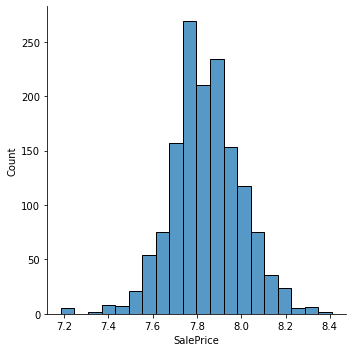

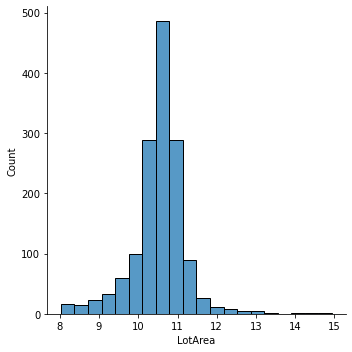

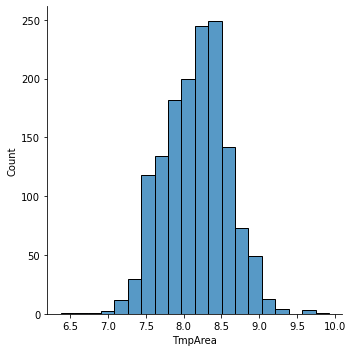

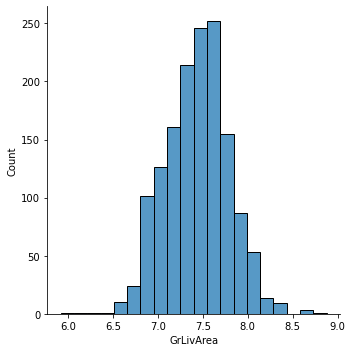

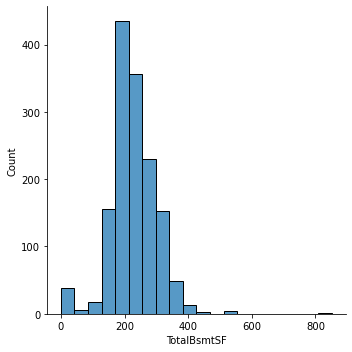

In [45]:
# "Разбираюсь" с выбросами - в итоге все на BoxCox

outliers_cols = ["LotArea", "TmpArea", "GrLivArea", "TotalBsmtSF"]
# В TotalBsmtSF есть 0 значение, для boxcox нельзя
data_train["TotalBsmtSF"] += 1
data_test["TotalBsmtSF"] += 1

data_train["SalePrice"], boxcox_lambda = scipy.stats.boxcox(data_train["SalePrice"])
sns.displot(data_train["SalePrice"], bins=20)

for col in outliers_cols:
    data_train[col], tmp_lambda = scipy.stats.boxcox(data_train[col], lmbda=None)
    data_test[col] = scipy.stats.boxcox(data_test[col], lmbda=tmp_lambda)
    sns.displot(data_train[col], bins=20)


In [46]:
train_X, val_X, train_y, val_y = sklearn.model_selection.train_test_split(
    data_train[important_features],
    data_train['SalePrice'],
    train_size=0.8,
    random_state=2021
)

test_X = data_test[important_features]

In [47]:
train_pool = catboost.Pool(train_X, label=train_y, cat_features=cat_features)
val_pool = catboost.Pool(val_X, label=val_y, cat_features=cat_features)
test_pool = catboost.Pool(
    test_X,
    # label=test_y,
    cat_features=cat_features,
)


In [48]:
?catboost.CatBoostRegressor
!rm -rf 'catboost_pricing2/snapshot.bkp'

"rm" ­Ґ пў«пҐвбп ў­гваҐ­­Ґ© Ё«Ё ў­Ґи­Ґ©
Є®¬ ­¤®©, ЁбЇ®«­пҐ¬®© Їа®Ја ¬¬®© Ё«Ё Ї ЄҐв­л¬ д ©«®¬.


In [49]:
catboost_train_dir = 'catboost_pricing2'
model = catboost.CatBoostRegressor(
    od_pval=0.05,
    od_wait=20,
    random_seed=2021,
    train_dir=catboost_train_dir,
    task_type='CPU',
    max_ctr_complexity=4,
    use_best_model=True
)
model.fit(
    train_pool, 
    eval_set=val_pool,
    plot=True,
    save_snapshot=True,
    snapshot_file='snapshot.bkp',
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.04745
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.04459149368
bestIteration = 554

Shrink model to first 555 iterations.


In [50]:
test_metrics = model.eval_metrics(
    val_pool,
    metrics=['SMAPE', 'R2'],
    ntree_start=model.best_iteration_ - 1,
    ntree_end=model.best_iteration_,
    eval_period=1,
    thread_count=-1
)
test_metrics

{'SMAPE': [0.3932282504444105], 'R2': [0.9125256244596712]}

Processing trees...
128/555 trees processed	passed time: 51.3ms	remaining time: 171ms
555/555 trees processed	passed time: 202ms	remaining time: 0us
Processing documents...
128/1168 documents processed	passed time: 4.81ms	remaining time: 39.1ms
1168/1168 documents processed	passed time: 40ms	remaining time: 0us


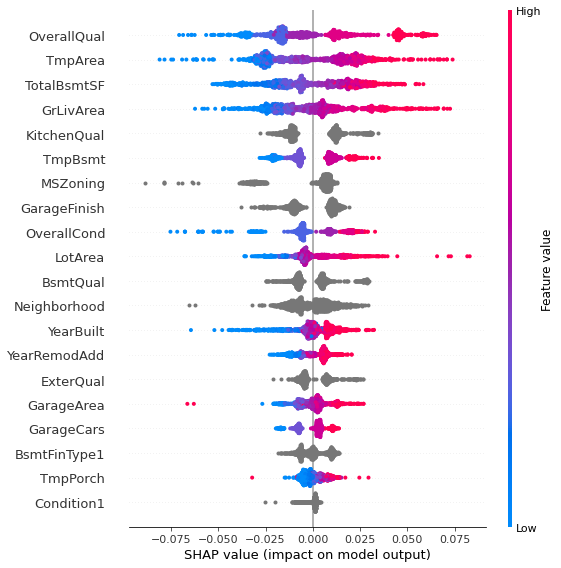

In [51]:
# Оцениваю влияние признаков

shap_info = model.get_feature_importance(
    data=train_pool, 
    type='ShapValues', 
    verbose=10000
)
shap_values = shap_info[:,:-1]
base_values = shap_info[:,-1]
shap.summary_plot(shap_values, train_X)

### Полученные результаты
- CatBoost - 0.14215 (5324 место)

## LGBM v1, в лоб 

In [52]:
encoded_df = pd.concat((train_df, test_df), axis=0)
encoded_df[categorical_columns] = (
    encoded_df[categorical_columns].astype(str).apply(LabelEncoder().fit_transform)
)

drop_columns = ['Utilities', 'PoolQC', 'PoolArea', 'Street']

In [53]:
train_X, val_X, train_y, val_y = sklearn.model_selection.train_test_split(
    encoded_df[~encoded_df['SalePrice'].isna()].drop(columns =  ['Id',target_name]),
    encoded_df[~encoded_df['SalePrice'].isna()][target_name],
    test_size = 0.2,
    shuffle = True,
    random_state=2021
)

In [54]:
train_data = lgb.Dataset(
    data=train_X,
    label=train_y,
    free_raw_data=False,
    categorical_feature=list(
        set(categorical_columns)
        - set(drop_columns)
    ),
)
validation_data = lgb.Dataset(
    data=val_X,
    label=val_y,
    free_raw_data=False,
    reference=train_data,
    categorical_feature=list(
        set(categorical_columns)
        - set(drop_columns)
    ),
)


In [55]:
param = {
    "num_leaves": 41,
    "objective": "regression_l1",
    "max_depth": -1,
    "metric": "rmse",
    "lambda_l1": 0.1,
    "learning_rate": 0.05,
}

num_round = 250
lgb_reg = lgb.train(param, train_data, num_round, valid_sets=[validation_data])


Using categorical_feature in Dataset.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001012 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3323
[LightGBM] [Info] Number of data points in the train set: 1168, number of used features: 77
[LightGBM] [Info] Start training from score 163000.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's rmse: 76000.1
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	valid_0's rmse: 74275.9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	valid_0's rmse: 72751.5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	valid_0's rmse: 71243
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	valid_0's rmse: 69780.7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6]	valid_0's rmse: 68319.1
[LightGBM] [Warning] No further spl

In [56]:
lgb_reg.predict(encoded_df[encoded_df['SalePrice'].isna()].drop(columns = ['Id', target_name]))

array([130672.11060685, 158495.32901262, 187077.49491553, ...,
       172509.84518598, 120321.3333665 , 203452.25573821])

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

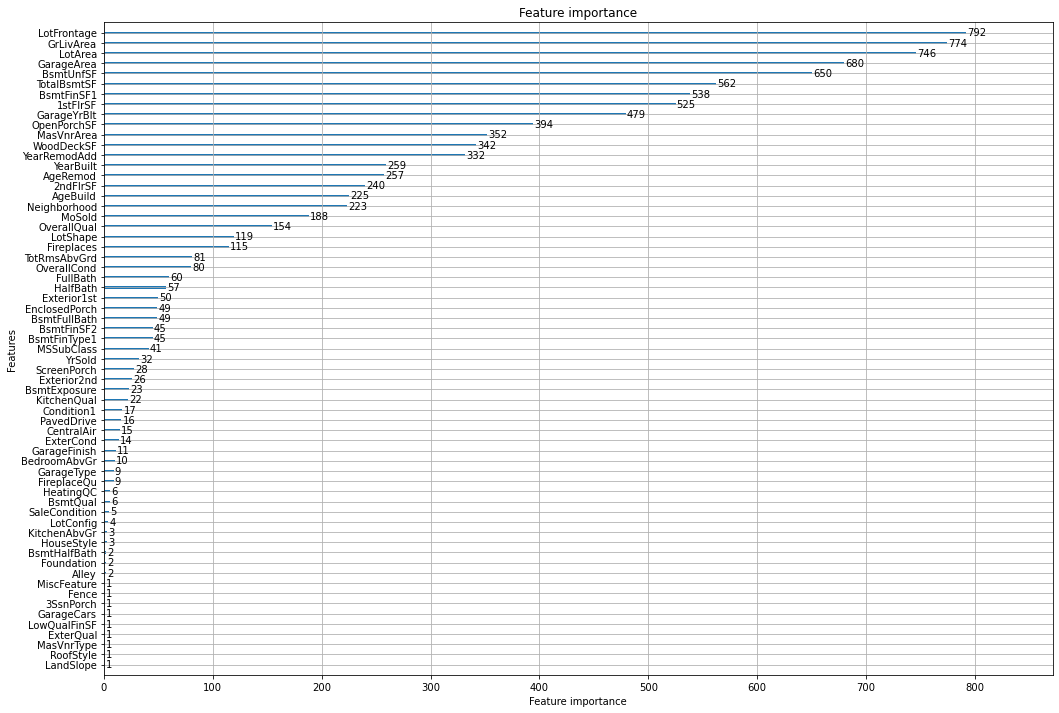

In [57]:
feat_imp = lgb_reg.feature_importance()
feat_imp_name = lgb_reg.feature_name()
fig, axes = plt.subplots(figsize = (17,12))
lgb.plot_importance(lgb_reg, ax = axes)

In [59]:

explainer = shap.TreeExplainer(lgb_reg) # insert your model
shap_values = explainer.shap_values(train_X) # insert your train Pool object

shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[:100], train_X[:100])


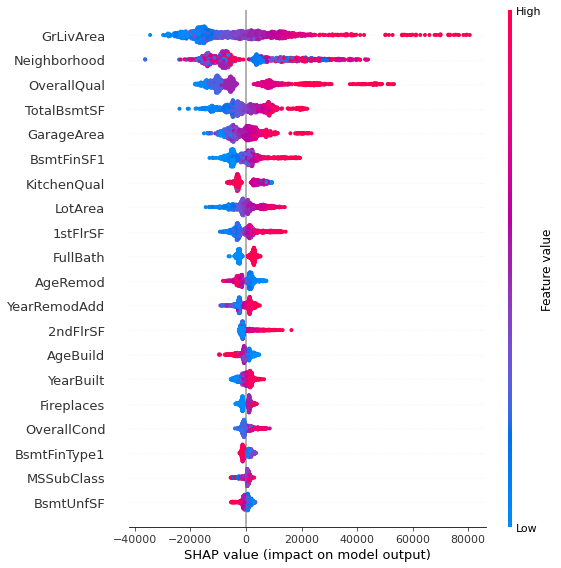

In [60]:
shap.summary_plot(shap_values, train_X)

## LGBM v2, KFold  - лучшее по метрике

In [61]:
float_columns = [
    "LotFrontage",
    "LotArea",
    "OverallQual",
    "MasVnrArea",
    "BsmtFinSF1",
    "BsmtFinSF2",
    "BsmtUnfSF",
    "TotalBsmtSF",
    "1stFlrSF",
    "2ndFlrSF",
    "GrLivArea",
    "TotRmsAbvGrd",
    "GarageArea",
    "WoodDeckSF",
    "OpenPorchSF",
    "EnclosedPorch",
    "ScreenPorch",
    "YearBuilt",
    "YearRemodAdd",
    "GarageYrBlt",
    "MoSold",
    "YrSold",
]

categorical_columns = [
    "MSSubClass",
    "LotShape",
    "Neighborhood",
    "Condition1",
    "OverallCond",
    "Exterior1st",
    "Exterior2nd",
    "ExterCond",
    "BsmtQual",
    "BsmtExposure",
    "HeatingQC",
    "KitchenQual",
    "FireplaceQu",
    "GarageFinish",
    "PavedDrive",
    "SaleCondition",
    "BsmtFullBath",
    "BsmtHalfBath",
    "FullBath",
    "HalfBath",
    "BedroomAbvGr",
    "Fireplaces",
    "GarageType",
    "CentralAir",
]


In [62]:
df = pd.concat((train_df, test_df), axis = 0)
df = df[float_columns+categorical_columns +['SalePrice', 'Id']]

In [63]:
def target_encoding(n = 9):
    categ_nunique = df[categorical_columns].nunique()
    target_encoding = categ_nunique[categ_nunique>n].index
    for col in target_encoding:
        feature_name = col + "Rank"
        df.loc[:, feature_name] = df[col].map(df.groupby(col).SalePrice.median())
        df.loc[:, feature_name] = df.loc[:, feature_name].rank(method = "dense")
        df.drop(columns = col, inplace = True)
        categorical_columns.remove(col)
    return [col + 'Rank' for col in target_encoding]
target_encoding_cols = target_encoding(9)

In [64]:
df[categorical_columns] = df[categorical_columns].astype(str).apply(LabelEncoder().fit_transform)

scaler = RobustScaler()

df[float_columns] = scaler.fit_transform(df[float_columns])
df[float_columns] = scaler.transform(df[float_columns])

In [65]:
data_train = df[~df['SalePrice'].isna()]
data_test = df[df['SalePrice'].isna()].drop(columns = 'SalePrice')

In [66]:
def model(features, test_features, n_folds = 4):
    
    """
    
    Return
    --------
        submission (pd.DataFrame): 
            dataframe with `SK_ID_CURR` and `TARGET` probabilities
            predicted by the model.
        feature_importances (pd.DataFrame): 
            dataframe with the feature importances from the model.
        valid_metrics (pd.DataFrame): 
            dataframe with training and validation metrics (ROC AUC) for each fold and overall.
        
    """
    
    labels = np.array(features[target_name])
    features = features.drop(columns = [target_name])
        
    print('Training Data Shape: ', features.shape)
    print('Testing Data Shape: ', test_features.shape)
    
    feature_names = list(features.columns)
    
    features = np.array(features)
    test_features = np.array(test_features)
    
    k_fold = KFold(n_splits = n_folds, shuffle = True, random_state = 50)
    
    feature_importance_values = np.zeros(len(feature_names))
    
    test_predictions = np.zeros(test_features.shape[0])
    
    out_of_fold = np.zeros(features.shape[0])
    
    valid_scores = []
    train_scores = []
        
    for train_indices, valid_indices in k_fold.split(features):
        
        train_features, train_labels = features[train_indices], labels[train_indices]
        valid_features, valid_labels = features[valid_indices], labels[valid_indices]
        
        model = lgb.LGBMRegressor(n_estimators=10000, objective = 'regression', learning_rate = 0.05, 
                                   reg_alpha = 0.1, reg_lambda = 0.1, 
                                   subsample = 0.8, n_jobs = -1, random_state = 41)
        
        model.fit(train_features, train_labels, eval_metric = 'rmse',
                  eval_set = [(valid_features, valid_labels), (train_features, train_labels)],
                  eval_names = ['valid', 'train'],
                  early_stopping_rounds = 1000, verbose = 200)
        
        best_iteration = model.best_iteration_
        
        feature_importance_values += model.feature_importances_ / k_fold.n_splits
        
        test_predictions += model.predict(test_features, num_iteration = best_iteration)/ k_fold.n_splits
        
        out_of_fold[valid_indices] = model.predict(valid_features, num_iteration = best_iteration)
    
        valid_score = model.best_score_['valid']['rmse']
        train_score = model.best_score_['train']['rmse']
        
        valid_scores.append(valid_score)
        train_scores.append(train_score)
        
    submission = pd.DataFrame({target_name: test_predictions})
    
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importance_values})
    
    valid_rmse = mean_squared_error(labels, out_of_fold)
    
    valid_scores.append(valid_rmse)
    train_scores.append(np.mean(train_scores))
    
    fold_names = list(range(n_folds))
    fold_names.append('overall')
    
    metrics = pd.DataFrame({'fold': fold_names,
                            'train': train_scores,
                            'valid': valid_scores}) 
    
    return submission, feature_importances, metrics

In [ ]:
feature_columns = categorical_columns   + target_encoding_cols + float_columns
submission, fi, metrics = model(data_train[feature_columns + ['SalePrice']], data_test[feature_columns])

Training Data Shape:  (1460, 46)
Testing Data Shape:  (1459, 46)
Training until validation scores don't improve for 1000 rounds
[200]	train's rmse: 12508.9	train's l2: 1.56472e+08	valid's rmse: 23824.7	valid's l2: 5.67614e+08
[400]	train's rmse: 7588.89	train's l2: 5.75912e+07	valid's rmse: 24692.7	valid's l2: 6.09728e+08
[600]	train's rmse: 4891.82	train's l2: 2.39299e+07	valid's rmse: 25306.8	valid's l2: 6.40434e+08
[800]	train's rmse: 3172.96	train's l2: 1.00677e+07	valid's rmse: 25507.5	valid's l2: 6.50634e+08
[1000]	train's rmse: 2006.49	train's l2: 4.02599e+06	valid's rmse: 25582.1	valid's l2: 6.54442e+08
Early stopping, best iteration is:
[105]	train's rmse: 17529.7	train's l2: 3.0729e+08	valid's rmse: 23083.3	valid's l2: 5.32838e+08
Training until validation scores don't improve for 1000 rounds
[200]	train's rmse: 10999.6	train's l2: 1.20991e+08	valid's rmse: 30926.4	valid's l2: 9.56445e+08
[400]	train's rmse: 6475.07	train's l2: 4.19265e+07	valid's rmse: 31070.6	valid's l2: 9.

In [ ]:
display(fi.sort_values('importance')[:10:-1])

In [ ]:
display(metrics)

In [ ]:
test_df['SalePrice'] =submission
test_df.to_csv("submission.csv", columns=["Id", "SalePrice"], index=False)

### Полученные результаты
- LGBM v1 - 0.14507
- LGBM v2 - 0.13468
- LGBM v2, target encoding - 0.13314 (3990)